# Notebook to process mutations found in genomes of 5-FC mutants

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'
from matplotlib.patches import FancyArrow
from matplotlib import cm
from upsetplot import from_indicators
from upsetplot import UpSet

## Specify filepaths

In [2]:
samtools_list_SNPs = 'data/samtools_variants_SNP.tab'
samtools_list_INDELs = 'data/samtools_variants_INDEL.tab'
gatk_list_SNPs = 'data/gatk_variants_SNP.tab'
gatk_list_INDELs = 'data/gatk_variants_INDEL.tab'
Sanger_list_mutations = 'data/layouts_FUR1_Sanger.xlsx'
layout_path = 'data/20220517_mutant_plates_rearray.xlsx'
graph_outpath = 'graphs/'
path_to_codon_table = 'data/ScerevisiaeTAXID559292_Cocoputs_codon_table.csv'
fitness_data = 'data/rhop30.xlsx'
fitness37_data = 'data/rhop37_22h.xlsx'
mutfunc_stab_path = 'data/YHR128W_stability.tab'
mutfunc_cons_path = 'data/YHR128W_conservation.tab'

## Parse output from samtools and gatk

In [10]:
samtools1_df = pd.read_csv(samtools_list_SNPs, sep='\t', index_col=0)
samtools2_df = pd.read_csv(samtools_list_INDELs, sep='\t', index_col=0)
samtools_df = pd.concat([samtools1_df, samtools2_df])
samtools_df['detected_by'] = 'samtools'
samtools_df

,#CHROM,POS,REF,ALT,GENE,mutID,MUT_ALL,ANN,GT,sample,snp,background,_merge,NGENE,GENE_SYMBOL,GENE_NAME,detected_by
0,chrI,77527,A,G,YAL035W,chrI:77527:A:G:synonymous_variant,G:synonymous_variant:YAL035W/G:upstream_gene_v...,G|synonymous_variant|LOW|YAL035W_CDS|GENE_YAL0...,"1:42,0:4:0,1:0,3:0,4:41",F4,1,LL13-040,left_only,YAL035W,FUN12,Function Unknown Now,samtools
1,chrI,77527,A,G,YAL035W,chrI:77527:A:G:synonymous_variant,G:synonymous_variant:YAL035W/G:upstream_gene_v...,G|synonymous_variant|LOW|YAL035W_CDS|GENE_YAL0...,"1:86,0:8:0,3:0,5:0,8:85",F5,1,LL13-040,left_only,YAL035W,FUN12,Function Unknown Now,samtools
2,chrI,77527,A,G,YAL035W,chrI:77527:A:G:synonymous_variant,G:synonymous_variant:YAL035W/G:upstream_gene_v...,G|synonymous_variant|LOW|YAL035W_CDS|GENE_YAL0...,"1:55,0:8:1,6:0,1:1,7:54",J2,1,LL13-040,left_only,YAL035W,FUN12,Function Unknown Now,samtools
3,chrI,77527,A,G,YAL035W,chrI:77527:A:G:synonymous_variant,G:synonymous_variant:YAL035W/G:upstream_gene_v...,G|synonymous_variant|LOW|YAL035W_CDS|GENE_YAL0...,"1:45,1:7:0,5:1,1:1,6:43",L2,1,LL13-040,left_only,YAL035W,FUN12,Function Unknown Now,samtools
4,chrI,77527,A,G,YAL035W,chrI:77527:A:G:synonymous_variant,G:synonymous_variant:YAL035W/G:upstream_gene_v...,G|synonymous_variant|LOW|YAL035W_CDS|GENE_YAL0...,"1:63,0:7:0,2:1,3:1,5:62",M4,1,LL13-040,left_only,YAL035W,FUN12,Function Unknown Now,samtools
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8456,chrmt,57978,T,"TATATATA,TATATATATA",YNCQ0006W,chrmt:57978:T:TATATATA:upstream_gene_variant,TATATATA:upstream_gene_variant:YNCQ0006W/TATAT...,TATATATA|upstream_gene_variant|MODIFIER|YNCQ00...,"1:15,0,15:5:0,0,0:0,5,0:0,5,0:127",O13,1,NC-02,left_only,YNCQ0006W,UNK,UNK,samtools
8457,chrmt,57978,T,"TATATATA,TATATATATA",YNCQ0006W,chrmt:57978:T:TATATATA:upstream_gene_variant,TATATATA:upstream_gene_variant:YNCQ0006W/TATAT...,TATATATA|upstream_gene_variant|MODIFIER|YNCQ00...,"1:82,0,79:16:0,2,0:0,13,1:0,15,1:127",O14,1,NC-02,left_only,YNCQ0006W,UNK,UNK,samtools
8458,chrmt,57978,T,"TATATATA,TATATATATA",YNCQ0006W,chrmt:57978:T:TATATATA:upstream_gene_variant,TATATATA:upstream_gene_variant:YNCQ0006W/TATAT...,TATATATA|upstream_gene_variant|MODIFIER|YNCQ00...,"1:50,0,50:11:0,1,0:0,10,0:0,11,0:127",O17,1,NC-02,left_only,YNCQ0006W,UNK,UNK,samtools
8459,chrmt,57978,T,"TATATATA,TATATATATA",YNCQ0006W,chrmt:57978:T:TATATATA:upstream_gene_variant,TATATATA:upstream_gene_variant:YNCQ0006W/TATAT...,TATATATA|upstream_gene_variant|MODIFIER|YNCQ00...,"1:10,0,2:12:0,0,0:0,10,2:0,10,2:127",O18,1,NC-02,left_only,YNCQ0006W,UNK,UNK,samtools


In [11]:
gatk1_df = pd.read_csv(gatk_list_SNPs, sep='\t', index_col=0)
gatk2_df = pd.read_csv(gatk_list_INDELs, sep='\t', index_col=0)
gatk_df = pd.concat([gatk1_df, gatk2_df])
gatk_df['detected_by'] = 'gatk'
gatk_df

,#CHROM,POS,REF,ALT,GENE,mutID,MUT_ALL,ANN,GT,sample,snp,background,_merge,NGENE,GENE_SYMBOL,GENE_NAME,detected_by
0,chrI,353,C,T,YAL069W,chrI:353:C:T:missense_variant,T:missense_variant:YAL069W/T:upstream_gene_var...,T|missense_variant|MODERATE|YAL069W_CDS|GENE_Y...,"1:0,23:23:PASS:99:995,0",B10,1,LL13-040,left_only,YAL069W,UNK,UNK,gatk
1,chrI,353,C,T,YAL069W,chrI:353:C:T:missense_variant,T:missense_variant:YAL069W/T:upstream_gene_var...,T|missense_variant|MODERATE|YAL069W_CDS|GENE_Y...,"1:0,22:22:PASS:99:974,0",B13,1,LL13-040,left_only,YAL069W,UNK,UNK,gatk
2,chrI,353,C,T,YAL069W,chrI:353:C:T:missense_variant,T:missense_variant:YAL069W/T:upstream_gene_var...,T|missense_variant|MODERATE|YAL069W_CDS|GENE_Y...,"1:0,60:60:PASS:99:2628,0",B4,1,LL13-040,left_only,YAL069W,UNK,UNK,gatk
3,chrI,353,C,T,YAL069W,chrI:353:C:T:missense_variant,T:missense_variant:YAL069W/T:upstream_gene_var...,T|missense_variant|MODERATE|YAL069W_CDS|GENE_Y...,"1:0,55:55:PASS:99:2324,0",B5,1,LL13-040,left_only,YAL069W,UNK,UNK,gatk
4,chrI,353,C,T,YAL069W,chrI:353:C:T:missense_variant,T:missense_variant:YAL069W/T:upstream_gene_var...,T|missense_variant|MODERATE|YAL069W_CDS|GENE_Y...,"1:0,46:46:PASS:99:1907,0",B6,1,LL13-040,left_only,YAL069W,UNK,UNK,gatk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24211,chrmt,80606,T,TTATATATATTTTATATATATTTTATATATATTATA,YNCQ0026W,chrmt:80606:T:TTATATATATTTTATATATATTTTATATATAT...,TTATATATATTTTATATATATTTTATATATATTATA:upstream_...,TTATATATATTTTATATATATTTTATATATATTATA|upstream_...,"1:0,9:9:PASS:99:405,0",C14,1,NC-02,left_only,YNCQ0026W,UNK,UNK,gatk
24212,chrmt,80606,T,TTATATATATTTTATATATATTTTATATATATTATA,YNCQ0026W,chrmt:80606:T:TTATATATATTTTATATATATTTTATATATAT...,TTATATATATTTTATATATATTTTATATATATTATA:upstream_...,TTATATATATTTTATATATATTTTATATATATTATA|upstream_...,"1:0,11:11:PASS:99:495,0",F16,1,NC-02,left_only,YNCQ0026W,UNK,UNK,gatk
24213,chrmt,80606,T,TTATATATATTTTATATATATTTTATATATATTATA,YNCQ0026W,chrmt:80606:T:TTATATATATTTTATATATATTTTATATATAT...,TTATATATATTTTATATATATTTTATATATATTATA:upstream_...,TTATATATATTTTATATATATTTTATATATATTATA|upstream_...,"1:0,18:18:PASS:99:809,0",F19,1,NC-02,left_only,YNCQ0026W,UNK,UNK,gatk
24214,chrmt,80606,T,TTATATATATTTTATATATATTTTATATATATTATA,YNCQ0026W,chrmt:80606:T:TTATATATATTTTATATATATTTTATATATAT...,TTATATATATTTTATATATATTTTATATATATTATA:upstream_...,TTATATATATTTTATATATATTTTATATATATTATA|upstream_...,"1:0,38:38:PASS:99:1705,0",J21,1,NC-02,left_only,YNCQ0026W,UNK,UNK,gatk


In [12]:
wgs_df = pd.concat([samtools_df, gatk_df], ignore_index=True)
wgs_df

,#CHROM,POS,REF,ALT,GENE,mutID,MUT_ALL,ANN,GT,sample,snp,background,_merge,NGENE,GENE_SYMBOL,GENE_NAME,detected_by
0,chrI,77527,A,G,YAL035W,chrI:77527:A:G:synonymous_variant,G:synonymous_variant:YAL035W/G:upstream_gene_v...,G|synonymous_variant|LOW|YAL035W_CDS|GENE_YAL0...,"1:42,0:4:0,1:0,3:0,4:41",F4,1,LL13-040,left_only,YAL035W,FUN12,Function Unknown Now,samtools
1,chrI,77527,A,G,YAL035W,chrI:77527:A:G:synonymous_variant,G:synonymous_variant:YAL035W/G:upstream_gene_v...,G|synonymous_variant|LOW|YAL035W_CDS|GENE_YAL0...,"1:86,0:8:0,3:0,5:0,8:85",F5,1,LL13-040,left_only,YAL035W,FUN12,Function Unknown Now,samtools
2,chrI,77527,A,G,YAL035W,chrI:77527:A:G:synonymous_variant,G:synonymous_variant:YAL035W/G:upstream_gene_v...,G|synonymous_variant|LOW|YAL035W_CDS|GENE_YAL0...,"1:55,0:8:1,6:0,1:1,7:54",J2,1,LL13-040,left_only,YAL035W,FUN12,Function Unknown Now,samtools
3,chrI,77527,A,G,YAL035W,chrI:77527:A:G:synonymous_variant,G:synonymous_variant:YAL035W/G:upstream_gene_v...,G|synonymous_variant|LOW|YAL035W_CDS|GENE_YAL0...,"1:45,1:7:0,5:1,1:1,6:43",L2,1,LL13-040,left_only,YAL035W,FUN12,Function Unknown Now,samtools
4,chrI,77527,A,G,YAL035W,chrI:77527:A:G:synonymous_variant,G:synonymous_variant:YAL035W/G:upstream_gene_v...,G|synonymous_variant|LOW|YAL035W_CDS|GENE_YAL0...,"1:63,0:7:0,2:1,3:1,5:62",M4,1,LL13-040,left_only,YAL035W,FUN12,Function Unknown Now,samtools
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64081,chrmt,80606,T,TTATATATATTTTATATATATTTTATATATATTATA,YNCQ0026W,chrmt:80606:T:TTATATATATTTTATATATATTTTATATATAT...,TTATATATATTTTATATATATTTTATATATATTATA:upstream_...,TTATATATATTTTATATATATTTTATATATATTATA|upstream_...,"1:0,9:9:PASS:99:405,0",C14,1,NC-02,left_only,YNCQ0026W,UNK,UNK,gatk
64082,chrmt,80606,T,TTATATATATTTTATATATATTTTATATATATTATA,YNCQ0026W,chrmt:80606:T:TTATATATATTTTATATATATTTTATATATAT...,TTATATATATTTTATATATATTTTATATATATTATA:upstream_...,TTATATATATTTTATATATATTTTATATATATTATA|upstream_...,"1:0,11:11:PASS:99:495,0",F16,1,NC-02,left_only,YNCQ0026W,UNK,UNK,gatk
64083,chrmt,80606,T,TTATATATATTTTATATATATTTTATATATATTATA,YNCQ0026W,chrmt:80606:T:TTATATATATTTTATATATATTTTATATATAT...,TTATATATATTTTATATATATTTTATATATATTATA:upstream_...,TTATATATATTTTATATATATTTTATATATATTATA|upstream_...,"1:0,18:18:PASS:99:809,0",F19,1,NC-02,left_only,YNCQ0026W,UNK,UNK,gatk
64084,chrmt,80606,T,TTATATATATTTTATATATATTTTATATATATTATA,YNCQ0026W,chrmt:80606:T:TTATATATATTTTATATATATTTTATATATAT...,TTATATATATTTTATATATATTTTATATATATTATA:upstream_...,TTATATATATTTTATATATATTTTATATATATTATA|upstream_...,"1:0,38:38:PASS:99:1705,0",J21,1,NC-02,left_only,YNCQ0026W,UNK,UNK,gatk


In [13]:
wgs_df.rename(columns={'sample':'RA_well'}, inplace=True)
wgs_df.drop(wgs_df[wgs_df.GENE_SYMBOL.str.contains('UNK')].index, inplace = True)
len(wgs_df)

49279

The following cell has been added to take into account cases where there are multiple alleles annotated. The first alt should be the correct one but **does not** necessarily correspond to the first listed in the mutID field. Sometimes there will also be two annotations with identical alt base but **not the same mutation type**.

In [14]:
wgs_df['mutID_len'] = wgs_df.mutID.apply(lambda x: len(x.split('/')))
wgs_df['mutID_1st_mutation'] = wgs_df[wgs_df['mutID_len'] > 1].mutID.apply(lambda x: x.split('/')[0].split(':')[-1])
wgs_df['mutID_2nd_mutation'] = wgs_df[wgs_df['mutID_len'] > 1].mutID.apply(lambda x: x.split('/')[1].split(':')[-1])
wgs_df[wgs_df['mutID_len'] > 1]

,#CHROM,POS,REF,ALT,GENE,mutID,MUT_ALL,ANN,GT,RA_well,snp,background,_merge,NGENE,GENE_SYMBOL,GENE_NAME,detected_by,mutID_len,mutID_1st_mutation,mutID_2nd_mutation
849,chrVIII,362230,C,"A,T",YHR128W/YHR128W,chrVIII:362230:C:A:missense_variant/T:missense...,A:missense_variant:YHR128W/T:missense_variant:...,A|missense_variant|MODERATE|YHR128W_CDS|GENE_Y...,"1:117,13,145:8:0,3,0:1,4,0:1,7,0:84",J12,1,LL13-040,left_only,YHR128W,FUR1,5-FluoroURidine resistant,samtools,2,missense_variant,missense_variant
850,chrVIII,362230,C,"A,T",YHR128W/YHR128W,chrVIII:362230:C:A:missense_variant/T:missense...,A:missense_variant:YHR128W/T:missense_variant:...,A|missense_variant|MODERATE|YHR128W_CDS|GENE_Y...,"1:255,0,255:32:0,15,0:0,17,0:0,32,0:127",L12,1,LL13-040,left_only,YHR128W,FUR1,5-FluoroURidine resistant,samtools,2,missense_variant,missense_variant
882,chrVIII,362424,G,"T,A",YHR128W/YHR128W,chrVIII:362424:G:A:missense_variant/T:missense...,A:missense_variant:YHR128W/T:missense_variant:...,A|missense_variant|MODERATE|YHR128W_CDS|GENE_Y...,"1:219,0,242:27:1,13,0:0,13,0:1,26,0:127",M12,1,LL13-040,left_only,YHR128W,FUR1,5-FluoroURidine resistant,samtools,2,missense_variant,missense_variant
929,chrVIII,362527,C,"T,A",YHR128W/YHR128W,chrVIII:362527:C:A:missense_variant/T:missense...,A:missense_variant:YHR128W/T:missense_variant:...,A|missense_variant|MODERATE|YHR128W_CDS|GENE_Y...,"1:243,0,243:21:0,12,0:0,9,0:0,21,0:127",C8,1,LL13-040,left_only,YHR128W,FUR1,5-FluoroURidine resistant,samtools,2,missense_variant,missense_variant
944,chrVIII,362691,G,"A,T",YHR128W/YHR128W,chrVIII:362691:G:A:missense_variant/T:missense...,A:missense_variant:YHR128W/T:missense_variant:...,A|missense_variant|MODERATE|YHR128W_CDS|GENE_Y...,"1:255,0,255:20:0,11,0:0,9,0:0,20,0:127",J6,1,LL13-040,left_only,YHR128W,FUR1,5-FluoroURidine resistant,samtools,2,missense_variant,missense_variant
945,chrVIII,362691,G,"A,T",YHR128W/YHR128W,chrVIII:362691:G:A:missense_variant/T:missense...,A:missense_variant:YHR128W/T:missense_variant:...,A|missense_variant|MODERATE|YHR128W_CDS|GENE_Y...,"1:255,0,255:31:0,16,0:0,15,0:0,31,0:127",M6,1,LL13-040,left_only,YHR128W,FUR1,5-FluoroURidine resistant,samtools,2,missense_variant,missense_variant
949,chrVIII,362731,T,"A,G",YHR128W/YHR128W,chrVIII:362731:T:A:stop_gained/G:missense_variant,A:stop_gained:YHR128W/G:missense_variant:YHR12...,A|stop_gained|HIGH|YHR128W_CDS|GENE_YHR128W_CD...,"1:246,0,246:52:0,40,0:0,11,0:0,51,0:127",J10,1,LL13-040,left_only,YHR128W,FUR1,5-FluoroURidine resistant,samtools,2,stop_gained,missense_variant
950,chrVIII,362733,G,"A,C",YHR128W/YHR128W,chrVIII:362733:G:A:missense_variant/C:missense...,A:missense_variant:YHR128W/C:missense_variant:...,A|missense_variant|MODERATE|YHR128W_CDS|GENE_Y...,"1:156,0,156:9:0,2,0:0,7,0:0,9,0:127",B12,1,LL13-040,left_only,YHR128W,FUR1,5-FluoroURidine resistant,samtools,2,missense_variant,missense_variant
951,chrVIII,362733,G,"A,C",YHR128W/YHR128W,chrVIII:362733:G:A:missense_variant/C:missense...,A:missense_variant:YHR128W/C:missense_variant:...,A|missense_variant|MODERATE|YHR128W_CDS|GENE_Y...,"1:237,0,237:26:0,10,0:0,16,0:0,26,0:127",D12,1,LL13-040,left_only,YHR128W,FUR1,5-FluoroURidine resistant,samtools,2,missense_variant,missense_variant
952,chrVIII,362733,G,"A,C",YHR128W/YHR128W,chrVIII:362733:G:A:missense_variant/C:missense...,A:missense_variant:YHR128W/C:missense_variant:...,A|missense_variant|MODERATE|YHR128W_CDS|GENE_Y...,"1:192,0,213:39:0,22,0:1,16,0:1,38,0:127",E11,1,LL13-040,left_only,YHR128W,FUR1,5-FluoroURidine resistant,samtools,2,missense_variant,missense_variant


In [15]:
print(len(wgs_df[wgs_df.mutID_len == 1]),len(wgs_df[wgs_df.mutID_len >= 2]))

49251 28


In [16]:
def find_correct_annotation(true_alt, original_annotation):
    annotations = original_annotation.split('/')
    if len(annotations) == 1:
        return annotations[0].split(':')[-1]
    elif len(annotations) > 1:
        # format of mutID annotation chr:pos:ref:alt1:type1/alt2:type2
        possible_annotations = [x for x in annotations if x.split(':')[-2] == true_alt]
        if len(possible_annotations) == 1:
            # Here we consider only the case where there's only two annotations (mutID), one of which is the correct one
            # Normally there should always be 2 different alts for each of those annotations
            # We get the annotation with the correct alt and extract the mutation type chr:pos:ref:alt1:TYPE1 (split(':')[-1])   
            return possible_annotations[0].split(':')[-1]
        else:
            # rare cases where true alt is found in multiple annotations
            possible_types = [x.split(':')[-1] for x in possible_annotations]
            if len(set(possible_types)) == 1:
                return possible_types[0]
            else:
                return 'undefined'
    else:
        return 'undefined'

In [17]:
find_correct_annotation('A', 'chrVIII:362731:T:A:stop_gained/G:missense_variant')

'stop_gained'

In [18]:
wgs_df['mut_type'] = wgs_df.apply(lambda row: find_correct_annotation(row.ALT.split(',')[0], row.mutID), axis=1)
wgs_df

,#CHROM,POS,REF,ALT,GENE,mutID,MUT_ALL,ANN,GT,RA_well,...,background,_merge,NGENE,GENE_SYMBOL,GENE_NAME,detected_by,mutID_len,mutID_1st_mutation,mutID_2nd_mutation,mut_type
0,chrI,77527,A,G,YAL035W,chrI:77527:A:G:synonymous_variant,G:synonymous_variant:YAL035W/G:upstream_gene_v...,G|synonymous_variant|LOW|YAL035W_CDS|GENE_YAL0...,"1:42,0:4:0,1:0,3:0,4:41",F4,...,LL13-040,left_only,YAL035W,FUN12,Function Unknown Now,samtools,1,NaN,NaN,synonymous_variant
1,chrI,77527,A,G,YAL035W,chrI:77527:A:G:synonymous_variant,G:synonymous_variant:YAL035W/G:upstream_gene_v...,G|synonymous_variant|LOW|YAL035W_CDS|GENE_YAL0...,"1:86,0:8:0,3:0,5:0,8:85",F5,...,LL13-040,left_only,YAL035W,FUN12,Function Unknown Now,samtools,1,NaN,NaN,synonymous_variant
2,chrI,77527,A,G,YAL035W,chrI:77527:A:G:synonymous_variant,G:synonymous_variant:YAL035W/G:upstream_gene_v...,G|synonymous_variant|LOW|YAL035W_CDS|GENE_YAL0...,"1:55,0:8:1,6:0,1:1,7:54",J2,...,LL13-040,left_only,YAL035W,FUN12,Function Unknown Now,samtools,1,NaN,NaN,synonymous_variant
3,chrI,77527,A,G,YAL035W,chrI:77527:A:G:synonymous_variant,G:synonymous_variant:YAL035W/G:upstream_gene_v...,G|synonymous_variant|LOW|YAL035W_CDS|GENE_YAL0...,"1:45,1:7:0,5:1,1:1,6:43",L2,...,LL13-040,left_only,YAL035W,FUN12,Function Unknown Now,samtools,1,NaN,NaN,synonymous_variant
4,chrI,77527,A,G,YAL035W,chrI:77527:A:G:synonymous_variant,G:synonymous_variant:YAL035W/G:upstream_gene_v...,G|synonymous_variant|LOW|YAL035W_CDS|GENE_YAL0...,"1:63,0:7:0,2:1,3:1,5:62",M4,...,LL13-040,left_only,YAL035W,FUN12,Function Unknown Now,samtools,1,NaN,NaN,synonymous_variant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64000,chrmt,60578,A,AATAATT,Q0160,chrmt:60578:A:AATAATT:upstream_gene_variant,AATAATT:upstream_gene_variant:Q0160/AATAATT:up...,AATAATT|upstream_gene_variant|MODIFIER|Q0160_C...,"1:0,197:197:PASS:99:8812,0",D16,...,NC-02,left_only,Q0160,SCEI,UNK,gatk,1,NaN,NaN,upstream_gene_variant
64001,chrmt,60578,A,AATAATT,Q0160,chrmt:60578:A:AATAATT:upstream_gene_variant,AATAATT:upstream_gene_variant:Q0160/AATAATT:up...,AATAATT|upstream_gene_variant|MODIFIER|Q0160_C...,"1:0,337:337:PASS:99:15027,0",G18,...,NC-02,left_only,Q0160,SCEI,UNK,gatk,1,NaN,NaN,upstream_gene_variant
64002,chrmt,60578,A,AATAATT,Q0160,chrmt:60578:A:AATAATT:upstream_gene_variant,AATAATT:upstream_gene_variant:Q0160/AATAATT:up...,AATAATT|upstream_gene_variant|MODIFIER|Q0160_C...,"1:0,160:160:PASS:99:7101,0",I21,...,NC-02,left_only,Q0160,SCEI,UNK,gatk,1,NaN,NaN,upstream_gene_variant
64003,chrmt,60578,A,AATAATT,Q0160,chrmt:60578:A:AATAATT:upstream_gene_variant,AATAATT:upstream_gene_variant:Q0160/AATAATT:up...,AATAATT|upstream_gene_variant|MODIFIER|Q0160_C...,"1:0,201:201:PASS:99:9006,0",K13,...,NC-02,left_only,Q0160,SCEI,UNK,gatk,1,NaN,NaN,upstream_gene_variant


In [19]:
wgs_df[wgs_df.mut_type == 'undefined'] # should be empty

,#CHROM,POS,REF,ALT,GENE,mutID,MUT_ALL,ANN,GT,RA_well,...,background,_merge,NGENE,GENE_SYMBOL,GENE_NAME,detected_by,mutID_len,mutID_1st_mutation,mutID_2nd_mutation,mut_type


In [20]:
# Checking that the proper mutation type has been retrieved / corresponds to the correct alt
wgs_df[(wgs_df.mutID_1st_mutation.notnull()) & (wgs_df.mutID_2nd_mutation.notnull()) & (wgs_df.mutID_1st_mutation != wgs_df.mutID_2nd_mutation)]

,#CHROM,POS,REF,ALT,GENE,mutID,MUT_ALL,ANN,GT,RA_well,...,background,_merge,NGENE,GENE_SYMBOL,GENE_NAME,detected_by,mutID_len,mutID_1st_mutation,mutID_2nd_mutation,mut_type
949,chrVIII,362731,T,"A,G",YHR128W/YHR128W,chrVIII:362731:T:A:stop_gained/G:missense_variant,A:stop_gained:YHR128W/G:missense_variant:YHR12...,A|stop_gained|HIGH|YHR128W_CDS|GENE_YHR128W_CD...,"1:246,0,246:52:0,40,0:0,11,0:0,51,0:127",J10,...,LL13-040,left_only,YHR128W,FUR1,5-FluoroURidine resistant,samtools,2,stop_gained,missense_variant,stop_gained


In [21]:
wgs_df.drop(wgs_df[wgs_df.mut_type == 'synonymous_variant'].index, inplace=True)
wgs_df

,#CHROM,POS,REF,ALT,GENE,mutID,MUT_ALL,ANN,GT,RA_well,...,background,_merge,NGENE,GENE_SYMBOL,GENE_NAME,detected_by,mutID_len,mutID_1st_mutation,mutID_2nd_mutation,mut_type
8,chrII,66697,A,G,YBL085W,chrII:66697:A:G:missense_variant,G:missense_variant:YBL085W/G:upstream_gene_var...,G|missense_variant|MODERATE|YBL085W_CDS|GENE_Y...,"1:255,0:42:0,24:0,18:0,42:127",I2,...,LL13-040,left_only,YBL085W,BOI1,Bem1 (One) Interacting protein,samtools,1,NaN,NaN,missense_variant
9,chrII,66697,A,G,YBL085W,chrII:66697:A:G:missense_variant,G:missense_variant:YBL085W/G:upstream_gene_var...,G|missense_variant|MODERATE|YBL085W_CDS|GENE_Y...,"1:159,0:28:1,24:0,3:1,27:127",J2,...,LL13-040,left_only,YBL085W,BOI1,Bem1 (One) Interacting protein,samtools,1,NaN,NaN,missense_variant
10,chrII,66697,A,G,YBL085W,chrII:66697:A:G:missense_variant,G:missense_variant:YBL085W/G:upstream_gene_var...,G|missense_variant|MODERATE|YBL085W_CDS|GENE_Y...,"1:212,0:19:0,13:0,6:0,19:127",K2,...,LL13-040,left_only,YBL085W,BOI1,Bem1 (One) Interacting protein,samtools,1,NaN,NaN,missense_variant
11,chrII,66697,A,G,YBL085W,chrII:66697:A:G:missense_variant,G:missense_variant:YBL085W/G:upstream_gene_var...,G|missense_variant|MODERATE|YBL085W_CDS|GENE_Y...,"1:250,0:25:0,13:0,12:0,25:127",L2,...,LL13-040,left_only,YBL085W,BOI1,Bem1 (One) Interacting protein,samtools,1,NaN,NaN,missense_variant
12,chrII,168004,G,A,YBL030C,chrII:168004:G:A:upstream_gene_variant,A:upstream_gene_variant:YBL030C/A:upstream_gen...,A|upstream_gene_variant|MODIFIER|YBL030C_CDS|G...,"1:235,0:44:0,27:0,17:0,44:127",D5,...,LL13-040,left_only,YBL030C,PET9,PETite,samtools,1,NaN,NaN,upstream_gene_variant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64000,chrmt,60578,A,AATAATT,Q0160,chrmt:60578:A:AATAATT:upstream_gene_variant,AATAATT:upstream_gene_variant:Q0160/AATAATT:up...,AATAATT|upstream_gene_variant|MODIFIER|Q0160_C...,"1:0,197:197:PASS:99:8812,0",D16,...,NC-02,left_only,Q0160,SCEI,UNK,gatk,1,NaN,NaN,upstream_gene_variant
64001,chrmt,60578,A,AATAATT,Q0160,chrmt:60578:A:AATAATT:upstream_gene_variant,AATAATT:upstream_gene_variant:Q0160/AATAATT:up...,AATAATT|upstream_gene_variant|MODIFIER|Q0160_C...,"1:0,337:337:PASS:99:15027,0",G18,...,NC-02,left_only,Q0160,SCEI,UNK,gatk,1,NaN,NaN,upstream_gene_variant
64002,chrmt,60578,A,AATAATT,Q0160,chrmt:60578:A:AATAATT:upstream_gene_variant,AATAATT:upstream_gene_variant:Q0160/AATAATT:up...,AATAATT|upstream_gene_variant|MODIFIER|Q0160_C...,"1:0,160:160:PASS:99:7101,0",I21,...,NC-02,left_only,Q0160,SCEI,UNK,gatk,1,NaN,NaN,upstream_gene_variant
64003,chrmt,60578,A,AATAATT,Q0160,chrmt:60578:A:AATAATT:upstream_gene_variant,AATAATT:upstream_gene_variant:Q0160/AATAATT:up...,AATAATT|upstream_gene_variant|MODIFIER|Q0160_C...,"1:0,201:201:PASS:99:9006,0",K13,...,NC-02,left_only,Q0160,SCEI,UNK,gatk,1,NaN,NaN,upstream_gene_variant


In [22]:
wgs_df.mut_type.unique()

array(['missense_variant', 'upstream_gene_variant',
       'initiator_codon_variant', 'start_lost', 'stop_gained',
       'disruptive_inframe_deletion', 'disruptive_inframe_insertion',
       'frameshift_variant', 'conservative_inframe_deletion',
       'conservative_inframe_insertion', 'downstream_gene_variant',
       'frameshift_variant&splice_region_variant',
       'splice_acceptor_variant&intron_variant',
       'splice_region_variant&intron_variant',
       'frameshift_variant&stop_gained',
       'frameshift_variant&stop_lost&splice_region_variant',
       'frameshift_variant&start_lost',
       'stop_gained&conservative_inframe_insertion',
       'stop_gained&disruptive_inframe_insertion'], dtype=object)

In [23]:
def find_mutation_type(m):
    
    indel_types = ['insertion', 'deletion', 'frameshift']
    SNP_types = ['missense', 'initiator', 'start_lost', 'stop_gained']
    
    if any(i in m for i in indel_types):
        return 'indel'
    elif any(i in m for i in SNP_types):
        return 'SNP'
    elif 'upstream' in m:
        return 'promoter'
    elif 'downstream' in m:
        return 'terminator'
    elif 'splice' in m:
        return 'splice variant'
    else:
        return 'undefined'

In [24]:
wgs_df[(wgs_df.mut_type.isnull()) | (wgs_df.mut_type == 'undefined')] # should be empty

,#CHROM,POS,REF,ALT,GENE,mutID,MUT_ALL,ANN,GT,RA_well,...,background,_merge,NGENE,GENE_SYMBOL,GENE_NAME,detected_by,mutID_len,mutID_1st_mutation,mutID_2nd_mutation,mut_type


In [25]:
wgs_df['mutation_type'] = wgs_df.mut_type.apply(lambda x: find_mutation_type(x))
wgs_df['ALT'] = wgs_df.ALT.apply(lambda x: x.split(',')[0])
wgs_df['mutID_true'] = wgs_df.apply(lambda row: row['#CHROM']+':'+str(row.POS)+':'+row.REF+'/'+row.ALT+':'+row.mutation_type, axis=1)
wgs_df

,#CHROM,POS,REF,ALT,GENE,mutID,MUT_ALL,ANN,GT,RA_well,...,NGENE,GENE_SYMBOL,GENE_NAME,detected_by,mutID_len,mutID_1st_mutation,mutID_2nd_mutation,mut_type,mutation_type,mutID_true
8,chrII,66697,A,G,YBL085W,chrII:66697:A:G:missense_variant,G:missense_variant:YBL085W/G:upstream_gene_var...,G|missense_variant|MODERATE|YBL085W_CDS|GENE_Y...,"1:255,0:42:0,24:0,18:0,42:127",I2,...,YBL085W,BOI1,Bem1 (One) Interacting protein,samtools,1,NaN,NaN,missense_variant,SNP,chrII:66697:A/G:SNP
9,chrII,66697,A,G,YBL085W,chrII:66697:A:G:missense_variant,G:missense_variant:YBL085W/G:upstream_gene_var...,G|missense_variant|MODERATE|YBL085W_CDS|GENE_Y...,"1:159,0:28:1,24:0,3:1,27:127",J2,...,YBL085W,BOI1,Bem1 (One) Interacting protein,samtools,1,NaN,NaN,missense_variant,SNP,chrII:66697:A/G:SNP
10,chrII,66697,A,G,YBL085W,chrII:66697:A:G:missense_variant,G:missense_variant:YBL085W/G:upstream_gene_var...,G|missense_variant|MODERATE|YBL085W_CDS|GENE_Y...,"1:212,0:19:0,13:0,6:0,19:127",K2,...,YBL085W,BOI1,Bem1 (One) Interacting protein,samtools,1,NaN,NaN,missense_variant,SNP,chrII:66697:A/G:SNP
11,chrII,66697,A,G,YBL085W,chrII:66697:A:G:missense_variant,G:missense_variant:YBL085W/G:upstream_gene_var...,G|missense_variant|MODERATE|YBL085W_CDS|GENE_Y...,"1:250,0:25:0,13:0,12:0,25:127",L2,...,YBL085W,BOI1,Bem1 (One) Interacting protein,samtools,1,NaN,NaN,missense_variant,SNP,chrII:66697:A/G:SNP
12,chrII,168004,G,A,YBL030C,chrII:168004:G:A:upstream_gene_variant,A:upstream_gene_variant:YBL030C/A:upstream_gen...,A|upstream_gene_variant|MODIFIER|YBL030C_CDS|G...,"1:235,0:44:0,27:0,17:0,44:127",D5,...,YBL030C,PET9,PETite,samtools,1,NaN,NaN,upstream_gene_variant,promoter,chrII:168004:G/A:promoter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64000,chrmt,60578,A,AATAATT,Q0160,chrmt:60578:A:AATAATT:upstream_gene_variant,AATAATT:upstream_gene_variant:Q0160/AATAATT:up...,AATAATT|upstream_gene_variant|MODIFIER|Q0160_C...,"1:0,197:197:PASS:99:8812,0",D16,...,Q0160,SCEI,UNK,gatk,1,NaN,NaN,upstream_gene_variant,promoter,chrmt:60578:A/AATAATT:promoter
64001,chrmt,60578,A,AATAATT,Q0160,chrmt:60578:A:AATAATT:upstream_gene_variant,AATAATT:upstream_gene_variant:Q0160/AATAATT:up...,AATAATT|upstream_gene_variant|MODIFIER|Q0160_C...,"1:0,337:337:PASS:99:15027,0",G18,...,Q0160,SCEI,UNK,gatk,1,NaN,NaN,upstream_gene_variant,promoter,chrmt:60578:A/AATAATT:promoter
64002,chrmt,60578,A,AATAATT,Q0160,chrmt:60578:A:AATAATT:upstream_gene_variant,AATAATT:upstream_gene_variant:Q0160/AATAATT:up...,AATAATT|upstream_gene_variant|MODIFIER|Q0160_C...,"1:0,160:160:PASS:99:7101,0",I21,...,Q0160,SCEI,UNK,gatk,1,NaN,NaN,upstream_gene_variant,promoter,chrmt:60578:A/AATAATT:promoter
64003,chrmt,60578,A,AATAATT,Q0160,chrmt:60578:A:AATAATT:upstream_gene_variant,AATAATT:upstream_gene_variant:Q0160/AATAATT:up...,AATAATT|upstream_gene_variant|MODIFIER|Q0160_C...,"1:0,201:201:PASS:99:9006,0",K13,...,Q0160,SCEI,UNK,gatk,1,NaN,NaN,upstream_gene_variant,promoter,chrmt:60578:A/AATAATT:promoter


In [26]:
wgs_df.to_excel('df/wgs_df.xlsx')

In [28]:
wgs_df = pd.read_excel('df/wgs_df.xlsx', index_col=0)
wgs_df

,#CHROM,POS,REF,ALT,GENE,mutID,MUT_ALL,ANN,GT,RA_well,...,NGENE,GENE_SYMBOL,GENE_NAME,detected_by,mutID_len,mutID_1st_mutation,mutID_2nd_mutation,mut_type,mutation_type,mutID_true
8,chrII,66697,A,G,YBL085W,chrII:66697:A:G:missense_variant,G:missense_variant:YBL085W/G:upstream_gene_var...,G|missense_variant|MODERATE|YBL085W_CDS|GENE_Y...,"1:255,0:42:0,24:0,18:0,42:127",I2,...,YBL085W,BOI1,Bem1 (One) Interacting protein,samtools,1,NaN,NaN,missense_variant,SNP,chrII:66697:A/G:SNP
9,chrII,66697,A,G,YBL085W,chrII:66697:A:G:missense_variant,G:missense_variant:YBL085W/G:upstream_gene_var...,G|missense_variant|MODERATE|YBL085W_CDS|GENE_Y...,"1:159,0:28:1,24:0,3:1,27:127",J2,...,YBL085W,BOI1,Bem1 (One) Interacting protein,samtools,1,NaN,NaN,missense_variant,SNP,chrII:66697:A/G:SNP
10,chrII,66697,A,G,YBL085W,chrII:66697:A:G:missense_variant,G:missense_variant:YBL085W/G:upstream_gene_var...,G|missense_variant|MODERATE|YBL085W_CDS|GENE_Y...,"1:212,0:19:0,13:0,6:0,19:127",K2,...,YBL085W,BOI1,Bem1 (One) Interacting protein,samtools,1,NaN,NaN,missense_variant,SNP,chrII:66697:A/G:SNP
11,chrII,66697,A,G,YBL085W,chrII:66697:A:G:missense_variant,G:missense_variant:YBL085W/G:upstream_gene_var...,G|missense_variant|MODERATE|YBL085W_CDS|GENE_Y...,"1:250,0:25:0,13:0,12:0,25:127",L2,...,YBL085W,BOI1,Bem1 (One) Interacting protein,samtools,1,NaN,NaN,missense_variant,SNP,chrII:66697:A/G:SNP
12,chrII,168004,G,A,YBL030C,chrII:168004:G:A:upstream_gene_variant,A:upstream_gene_variant:YBL030C/A:upstream_gen...,A|upstream_gene_variant|MODIFIER|YBL030C_CDS|G...,"1:235,0:44:0,27:0,17:0,44:127",D5,...,YBL030C,PET9,PETite,samtools,1,NaN,NaN,upstream_gene_variant,promoter,chrII:168004:G/A:promoter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64000,chrmt,60578,A,AATAATT,Q0160,chrmt:60578:A:AATAATT:upstream_gene_variant,AATAATT:upstream_gene_variant:Q0160/AATAATT:up...,AATAATT|upstream_gene_variant|MODIFIER|Q0160_C...,"1:0,197:197:PASS:99:8812,0",D16,...,Q0160,SCEI,UNK,gatk,1,NaN,NaN,upstream_gene_variant,promoter,chrmt:60578:A/AATAATT:promoter
64001,chrmt,60578,A,AATAATT,Q0160,chrmt:60578:A:AATAATT:upstream_gene_variant,AATAATT:upstream_gene_variant:Q0160/AATAATT:up...,AATAATT|upstream_gene_variant|MODIFIER|Q0160_C...,"1:0,337:337:PASS:99:15027,0",G18,...,Q0160,SCEI,UNK,gatk,1,NaN,NaN,upstream_gene_variant,promoter,chrmt:60578:A/AATAATT:promoter
64002,chrmt,60578,A,AATAATT,Q0160,chrmt:60578:A:AATAATT:upstream_gene_variant,AATAATT:upstream_gene_variant:Q0160/AATAATT:up...,AATAATT|upstream_gene_variant|MODIFIER|Q0160_C...,"1:0,160:160:PASS:99:7101,0",I21,...,Q0160,SCEI,UNK,gatk,1,NaN,NaN,upstream_gene_variant,promoter,chrmt:60578:A/AATAATT:promoter
64003,chrmt,60578,A,AATAATT,Q0160,chrmt:60578:A:AATAATT:upstream_gene_variant,AATAATT:upstream_gene_variant:Q0160/AATAATT:up...,AATAATT|upstream_gene_variant|MODIFIER|Q0160_C...,"1:0,201:201:PASS:99:9006,0",K13,...,Q0160,SCEI,UNK,gatk,1,NaN,NaN,upstream_gene_variant,promoter,chrmt:60578:A/AATAATT:promoter


In [29]:
wgs_wide = wgs_df.pivot_table(index=['background','RA_well','#CHROM','POS','REF','ALT','GENE_SYMBOL','mutation_type','mutID_true'], columns='detected_by', values='snp', fill_value=0).reset_index()
wgs_wide

detected_by,background,RA_well,#CHROM,POS,REF,ALT,GENE_SYMBOL,mutation_type,mutID_true,gatk,samtools
0,LL13-040,B10,chrI,2718,C,T,PAU8,promoter,chrI:2718:C/T:promoter,1,0
1,LL13-040,B10,chrI,2719,T,A,PAU8,promoter,chrI:2719:T/A:promoter,1,0
2,LL13-040,B10,chrI,178768,TGAA,T,CDC15,promoter,chrI:178768:TGAA/T:promoter,1,0
3,LL13-040,B10,chrI,198252,C,G,SWH1,terminator,chrI:198252:C/G:terminator,1,0
4,LL13-040,B10,chrII,122429,GAAAAAAAAAAAA,GAAAAAAAAAAAAAA,SAS3,promoter,chrII:122429:GAAAAAAAAAAAA/GAAAAAAAAAAAAAA:pro...,0,1
...,...,...,...,...,...,...,...,...,...,...,...
42387,NC-02,O22,chrXVI,378890,G,GCAATTTTACAC,RPS6A,promoter,chrXVI:378890:G/GCAATTTTACAC:promoter,1,0
42388,NC-02,O22,chrXVI,837812,ATATGTTTGCT,A,URN1,promoter,chrXVI:837812:ATATGTTTGCT/A:promoter,1,0
42389,NC-02,O22,chrmt,29205,AGGG,A,ATP6,indel,chrmt:29205:AGGG/A:indel,1,0
42390,NC-02,O22,chrmt,29214,T,TTTGA,ATP6,indel,chrmt:29214:T/TTTGA:indel,1,0


In [30]:
wgs_wide.to_excel('df/wgs_wide.xlsx')

In [31]:
wgs_wide = pd.read_excel('df/wgs_wide.xlsx', index_col=0)
wgs_wide

,background,RA_well,#CHROM,POS,REF,ALT,GENE_SYMBOL,mutation_type,mutID_true,gatk,samtools
0,LL13-040,B10,chrI,2718,C,T,PAU8,promoter,chrI:2718:C/T:promoter,1,0
1,LL13-040,B10,chrI,2719,T,A,PAU8,promoter,chrI:2719:T/A:promoter,1,0
2,LL13-040,B10,chrI,178768,TGAA,T,CDC15,promoter,chrI:178768:TGAA/T:promoter,1,0
3,LL13-040,B10,chrI,198252,C,G,SWH1,terminator,chrI:198252:C/G:terminator,1,0
4,LL13-040,B10,chrII,122429,GAAAAAAAAAAAA,GAAAAAAAAAAAAAA,SAS3,promoter,chrII:122429:GAAAAAAAAAAAA/GAAAAAAAAAAAAAA:pro...,0,1
...,...,...,...,...,...,...,...,...,...,...,...
42387,NC-02,O22,chrXVI,378890,G,GCAATTTTACAC,RPS6A,promoter,chrXVI:378890:G/GCAATTTTACAC:promoter,1,0
42388,NC-02,O22,chrXVI,837812,ATATGTTTGCT,A,URN1,promoter,chrXVI:837812:ATATGTTTGCT/A:promoter,1,0
42389,NC-02,O22,chrmt,29205,AGGG,A,ATP6,indel,chrmt:29205:AGGG/A:indel,1,0
42390,NC-02,O22,chrmt,29214,T,TTTGA,ATP6,indel,chrmt:29214:T/TTTGA:indel,1,0


In [20]:
bysample = wgs_wide.groupby(['background', 'RA_well']).agg(Ngenes = ('GENE_SYMBOL', 'nunique'), Lgenes = ('GENE_SYMBOL', 'unique'), gatk = ('gatk','max'), samtools= ('samtools','max')).reset_index()
#bysample.to_excel('data/20230324_bysample.xlsx')
bysample

,background,RA_well,Ngenes,Lgenes,gatk,samtools
0,LL13-040,B10,114,"[PAU8, CDC15, SWH1, SAS3, PRP6, TEC1, PHO5, GR...",1,1
1,LL13-040,B11,133,"[SEO1, CLN3, PHO11, FIG1, GRS1, TAF5, MAL33, P...",1,1
2,LL13-040,B12,116,"[FUN12, TFC3, SWH1, FLO1, CMC2, ERD2, YPK3, PR...",1,1
3,LL13-040,B13,116,"[PAU8, LTE1, PHO11, ERD2, PRP6, CDC28, PCA1, M...",1,1
4,LL13-040,B2,125,"[CLN3, PHO11, ERD2, PRP6, RPL19A, GRS1, AGP2, ...",1,1
...,...,...,...,...,...,...
275,NC-02,O17,121,"[PAU8, SEO1, DRS2, CCR4, FLO1, SCT1, KAP104, P...",1,1
276,NC-02,O18,93,"[PAU8, SEO1, DRS2, CCR4, FLO1, COR1, KAP104, T...",1,1
277,NC-02,O19,120,"[MDM10, FLO1, ILS1, CMC2, PRP6, TIP1, TAT1, RP...",1,1
278,NC-02,O21,105,"[DRS2, FLO1, COR1, KAP104, YPK3, PRP6, TAT1, R...",1,1


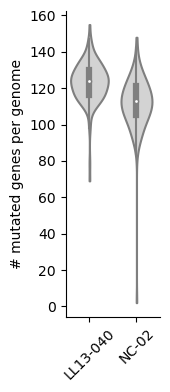

In [40]:
f, ax = plt.subplots(figsize=(1.8, 4.02))
fig = sns.violinplot(data=bysample, x='background', y='Ngenes', order=['LL13-040', 'NC-02'], cut=0, color='lightgrey', ax=ax)
fig.axes.set(xlabel='', ylabel='# mutated genes per genome')
fig.set_xticklabels(['LL13-040', 'NC-02'], rotation=45)
plt.tight_layout()
sns.despine()
plt.savefig(graph_outpath+'20230325_distri_genes_per_sample.png', format='png', dpi=300)
plt.savefig(graph_outpath+'20230325_distri_genes_per_sample.svg', format='svg', dpi=300)

In [41]:
bygene = wgs_wide.groupby(['background','GENE_SYMBOL']).agg(Nsamples = ('RA_well','nunique'), Nmut = ('mutID_true', 'nunique'), gatk = ('gatk','max'), samtools= ('samtools','max')).reset_index()
bygene

,background,GENE_SYMBOL,Nsamples,Nmut,gatk,samtools
0,LL13-040,AAD4,5,3,1,0
1,LL13-040,ACC1,2,2,1,0
2,LL13-040,ACK1,2,1,0,1
3,LL13-040,ACO2,3,6,1,0
4,LL13-040,ADE17,105,2,1,1
...,...,...,...,...,...,...
1539,NC-02,YSP2,1,1,1,0
1540,NC-02,YSY6,14,1,0,1
1541,NC-02,ZDS1,45,5,1,0
1542,NC-02,ZRT1,21,4,1,0


In [24]:
bygene_sorted = bygene.sort_values(by=['background', 'Nmut', 'Nsamples'],
                                   ascending=[True,True,True] # Note: this sorting order allows to draw dots in the proper zorder in the upset catplot
                                  ).astype({'gatk': bool, 'samtools': bool})
bygene_sorted

,background,GENE_SYMBOL,Nsamples,Nmut,gatk,samtools
10,LL13-040,AGE1,1,1,True,False
15,LL13-040,AIF1,1,1,True,False
17,LL13-040,AIM18,1,1,True,False
22,LL13-040,ALR1,1,1,True,False
24,LL13-040,AMF1,1,1,True,False
...,...,...,...,...,...,...
1156,NC-02,MAL31,82,14,True,False
1364,NC-02,RSN1,116,16,True,False
1031,NC-02,FLO1,75,29,True,True
951,NC-02,COS8,99,31,True,False


In [25]:
bygene_sorted[bygene_sorted.Nmut > 20]

,background,GENE_SYMBOL,Nsamples,Nmut,gatk,samtools
231,LL13-040,FLO1,68,30,True,False
384,LL13-040,MAL31,137,46,True,False
245,LL13-040,FUR1,136,58,True,True
1031,NC-02,FLO1,75,29,True,True
951,NC-02,COS8,99,31,True,False
1042,NC-02,FUR1,94,55,True,True


In [26]:
len(bygene_sorted[(bygene_sorted.background == 'LL13-040') & (bygene_sorted.gatk == True) & (bygene_sorted.samtools == True)].GENE_SYMBOL.unique())

110

## UpSet plots - All genes - samtools vs gatk

In [28]:
# Setting up color palette
Nmut_norm = plt.Normalize(bygene_sorted.Nmut.min(), bygene_sorted.Nmut.max())
sm = cm.ScalarMappable(cmap='cividis', norm=Nmut_norm)
sm.set_array([])

In [29]:
# Retrieving the 2 genes with the highest number of mutation for each combination of pipelines used for detection
# Only for genes predicted to be mutated by both pipelines

L2 = bygene_sorted[(bygene_sorted.background=='LL13-040') & (bygene_sorted.gatk==True) & (bygene_sorted.samtools==True)]
annotL2 = L2[L2.Nmut.isin(L2['Nmut'].nlargest(2))]
L2l = [[g, (2,n)] for g, n in zip(annotL2.GENE_SYMBOL, annotL2.Nsamples)] # change C in [[g, (C,n)] depending on the column where the labels should be drawn

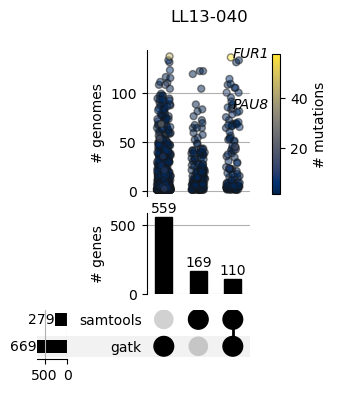

In [33]:
fig = plt.figure(figsize=(2.75, 4.02))
LL13_upset = UpSet(from_indicators(['gatk','samtools'], data=bygene_sorted[bygene_sorted.background=='LL13-040']),
                   #show_percentages=True,
                   show_counts=True,
                   sort_by='cardinality',
                   element_size=None,
                   intersection_plot_elements=3, # height of intersection barplot in matrix elements
                   totals_plot_elements = 1 # width of totals barplot in matrix elements
                  )

LL13_upset.add_catplot(value='Nsamples', kind='strip', hue='Nmut', palette='cividis', alpha=.5, linewidth=1, jitter=0.2,
                      elements=5 # height in number of matrix elements
                      )

d = LL13_upset.plot(fig=fig) # Assigns all plots to a dictionary containing axes subplots - same keys as gridspec returned by LL13_upset.make_grid()
ax_int = d['intersections'] # Key corresponding to intersection barplot
ax = d['extra1'] # Key corresponding to additional plot, in this case catplot
ax_int.set_ylabel('# genes')
ax.set_ylabel('# genomes')
ax.get_legend().remove()

# Custom color bar for catplot
cax = plt.axes([0.98, 0.52, 0.03, 0.35]) # left bottom width height -- easy fix to prevent from stealing space to adjacent plot
cbar = plt.colorbar(sm, cax=cax)
cbar.ax.set_ylabel('# mutations')

# Labeling dots on catplot
#for x in L0l:
#    ax.annotate(x[0], x[1])
for y in L2l:
    ax.annotate(y[0], y[1], style='italic')


plt.suptitle('LL13-040', x=0.75)

plt.savefig(graph_outpath + '20230413_upsetplot_LL13.svg', format='svg', dpi=300)

In [34]:
# Retrieving the 2 genes with the highest number of mutation for each combination of pipelines used for detection
# Only for genes predicted to be mutated by both pipelines

N2 = bygene_sorted[(bygene_sorted.background=='NC-02') & (bygene_sorted.gatk==True) & (bygene_sorted.samtools==True)]
annotN2 = N2[N2.Nmut.isin(N2['Nmut'].nlargest(2))]
N2l = [[g, (2,n)] for g, n in zip(annotN2.GENE_SYMBOL, annotN2.Nsamples)] # change C in [[g, (C,n)] depending on the column where the labels should be drawn

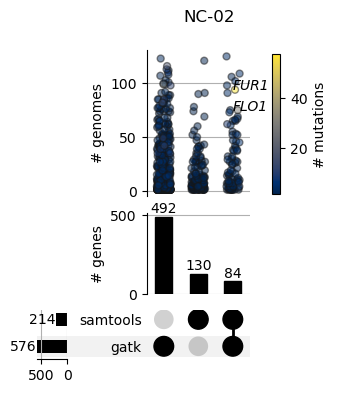

In [35]:
fig = plt.figure(figsize=(2.75, 4.02))
NC02_upset = UpSet(from_indicators(['gatk','samtools'], data=bygene_sorted[bygene_sorted.background=='NC-02']),
                   #show_percentages=True,
                   show_counts=True,
                   sort_by='cardinality',
                   element_size=None,
                   intersection_plot_elements=3, # height of intersection barplot in matrix elements
                   totals_plot_elements = 1 # width of totals barplot in matrix elements
                  )

NC02_upset.add_catplot(value='Nsamples', kind='strip', hue='Nmut', palette='cividis', alpha=.5, linewidth=1, jitter=0.2,
                      elements=5 # height in number of matrix elements
                      )

d = NC02_upset.plot(fig=fig) # Assigns all plots to a dictionary containing axes subplots - same keys as gridspec returned by LL13_upset.make_grid()
ax_int = d['intersections'] # Key corresponding to intersection barplot
ax = d['extra1'] # Key corresponding to additional plot, in this case catplot
ax_int.set_ylabel('# genes')
ax.set_ylabel('# genomes')
ax.get_legend().remove()

# Custom color bar for catplot
cax = plt.axes([0.98, 0.52, 0.03, 0.35]) # left bottom width height -- easy fix to prevent from stealing space to adjacent plot
cbar = plt.colorbar(sm, cax=cax)
cbar.ax.set_ylabel('# mutations')

# Labeling dots on catplot
#for x in N0l:
#    ax.annotate(x[0], x[1])
for y in N2l:
    ax.annotate(y[0], y[1], style='italic')


plt.suptitle('NC-02', x=0.75)

plt.savefig(graph_outpath + '20230413_upsetplot_NC02.svg', format='svg', dpi=300)

## Parse list of mutations identified by Sanger sequencing

In [44]:
Sanger_df = pd.read_excel(Sanger_list_mutations, sheet_name='list_Sanger_mutations').iloc[:,2:]
Sanger_df['detected_by'] = 'Sanger'
Sanger_df

,RA_well,mutation_type,mutation,SNP_pos_aa,ref_nt,alt_nt,POS,REF,ALT,detected_by
0,B11,indel,L21del,21.0,TTG,TT,362176.0,TG,T,Sanger
1,B13,indel,P204del,204.0,CCA,CC,362725.0,CA,C,Sanger
2,B20,indel,I83del,83.0,TCCATTGTCAGAGCTGGTGAATCGATGGAGCAAGGATTAAGAGACT...,TCC,362360.0,CATTGTCAGAGCTGGT,C,Sanger
3,B20,indel,S89del,89.0,ATCGATGGAGCAAGGATTAAGAGACTGTTGTAGGTCTGTGCGTATCGGT,A,362378.0,ATCGATGGAGCAAGGATTAAGAGACTGTTGTAGGTCTGTGCGTATCGGT,A,Sanger
4,C15,indel,A115ins,115.0,GCT,GCTT,362459.0,T,TT,Sanger
...,...,...,...,...,...,...,...,...,...,...
267,O3,SNP,R110G,110.0,AGG,GGG,362442.0,A,G,Sanger
268,O4,SNP,R110G,110.0,AGG,GGG,362442.0,A,G,Sanger
269,O5,SNP,R110G,110.0,AGG,GGG,362442.0,A,G,Sanger
270,O8,SNP,S89L,89.0,TCG,TTG,362380.0,C,T,Sanger


In [45]:
len(Sanger_df.RA_well.unique())

268

In [46]:
Sanger_df['ref_aa'] = Sanger_df.apply(lambda row: row.mutation[0] if row.mutation_type!='none' else np.nan, axis=1)
Sanger_df['alt_aa'] = Sanger_df.apply(lambda row: row.mutation[-1] if row.mutation_type in ['SNP', 'DNP'] else np.nan, axis=1)
Sanger_df['pos_nt'] = Sanger_df.apply(lambda row: row.POS - 362115 if row.mutation_type!='indel'
                                          else row.POS + 1 - 362115, # Adding +1 because samtools/gatk formatting for indels start at the conserved base at -1
                                          axis=1)
Sanger_df['mutID_true'] = Sanger_df.apply(lambda row: 'chrVIII:'+str(int(row.POS))+':'+row.REF+'/'+row.ALT+':'+row.mutation_type if row.mutation != 'WT' else '0:0/0', axis=1)
Sanger_df['snp'] = 1
Sanger_df

,RA_well,mutation_type,mutation,SNP_pos_aa,ref_nt,alt_nt,POS,REF,ALT,detected_by,ref_aa,alt_aa,pos_nt,mutID_true,snp
0,B11,indel,L21del,21.0,TTG,TT,362176.0,TG,T,Sanger,L,NaN,62.0,chrVIII:362176:TG/T:indel,1
1,B13,indel,P204del,204.0,CCA,CC,362725.0,CA,C,Sanger,P,NaN,611.0,chrVIII:362725:CA/C:indel,1
2,B20,indel,I83del,83.0,TCCATTGTCAGAGCTGGTGAATCGATGGAGCAAGGATTAAGAGACT...,TCC,362360.0,CATTGTCAGAGCTGGT,C,Sanger,I,NaN,246.0,chrVIII:362360:CATTGTCAGAGCTGGT/C:indel,1
3,B20,indel,S89del,89.0,ATCGATGGAGCAAGGATTAAGAGACTGTTGTAGGTCTGTGCGTATCGGT,A,362378.0,ATCGATGGAGCAAGGATTAAGAGACTGTTGTAGGTCTGTGCGTATCGGT,A,Sanger,S,NaN,264.0,chrVIII:362378:ATCGATGGAGCAAGGATTAAGAGACTGTTGT...,1
4,C15,indel,A115ins,115.0,GCT,GCTT,362459.0,T,TT,Sanger,A,NaN,345.0,chrVIII:362459:T/TT:indel,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,O3,SNP,R110G,110.0,AGG,GGG,362442.0,A,G,Sanger,R,G,327.0,chrVIII:362442:A/G:SNP,1
268,O4,SNP,R110G,110.0,AGG,GGG,362442.0,A,G,Sanger,R,G,327.0,chrVIII:362442:A/G:SNP,1
269,O5,SNP,R110G,110.0,AGG,GGG,362442.0,A,G,Sanger,R,G,327.0,chrVIII:362442:A/G:SNP,1
270,O8,SNP,S89L,89.0,TCG,TTG,362380.0,C,T,Sanger,S,L,265.0,chrVIII:362380:C/T:SNP,1


In [47]:
Sanger_df.groupby(['mutation_type', 'mutation']).agg(n_mutants = ('RA_well', 'nunique'))

n_mutants
mutation_type mutation           
SNP           A149T             1
              A86T              2
              A86V              2
              C79R              2
              C79Y              3
...                           ...
indel         S171ins           1
              S3del             2
              S89del            1
              V47del            1
none          WT               19

[111 rows x 1 columns]

In [48]:
Sanger_df[Sanger_df.mutation == 'WT']

,RA_well,mutation_type,mutation,SNP_pos_aa,ref_nt,alt_nt,POS,REF,ALT,detected_by,ref_aa,alt_aa,pos_nt,mutID_true,snp
28,B16,none,WT,NaN,NaN,NaN,NaN,NaN,NaN,Sanger,NaN,NaN,NaN,0:0/0,1
29,D2,none,WT,NaN,NaN,NaN,NaN,NaN,NaN,Sanger,NaN,NaN,NaN,0:0/0,1
30,D21,none,WT,NaN,NaN,NaN,NaN,NaN,NaN,Sanger,NaN,NaN,NaN,0:0/0,1
31,E23,none,WT,NaN,NaN,NaN,NaN,NaN,NaN,Sanger,NaN,NaN,NaN,0:0/0,1
32,F22,none,WT,NaN,NaN,NaN,NaN,NaN,NaN,Sanger,NaN,NaN,NaN,0:0/0,1
33,F23,none,WT,NaN,NaN,NaN,NaN,NaN,NaN,Sanger,NaN,NaN,NaN,0:0/0,1
34,G23,none,WT,NaN,NaN,NaN,NaN,NaN,NaN,Sanger,NaN,NaN,NaN,0:0/0,1
35,H13,none,WT,NaN,NaN,NaN,NaN,NaN,NaN,Sanger,NaN,NaN,NaN,0:0/0,1
36,H19,none,WT,NaN,NaN,NaN,NaN,NaN,NaN,Sanger,NaN,NaN,NaN,0:0/0,1
37,I13,none,WT,NaN,NaN,NaN,NaN,NaN,NaN,Sanger,NaN,NaN,NaN,0:0/0,1


### Export annotated mutations identified by Sanger

In [49]:
Sanger_df.to_excel('df/Sanger_df.xlsx')

## Merge dataframes of variants called by samtools, gatk and Sanger

### Select samtools and gatk FUR1 variants

In [32]:
FUR1_wgs_df = wgs_df[wgs_df.GENE_SYMBOL == 'FUR1']
FUR1_wgs_df['pos_nt'] = FUR1_wgs_df.apply(lambda row: row.POS - 362115 if row.mutation_type=='SNP'
                                          else row.POS + 1 - 362115, # Adding +1 because samtools/gatk formatting for indels start at the conserved base at -1
                                          axis=1)
FUR1_wgs_df['SNP_pos_aa'] = FUR1_wgs_df.pos_nt.apply(lambda x: (x//3) + 1)
FUR1_wgs_df

C:\Users\duran\AppData\Local\Temp\ipykernel_12292\2246076593.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FUR1_wgs_df['pos_nt'] = FUR1_wgs_df.apply(lambda row: row.POS - 362115 if row.mutation_type=='SNP'
C:\Users\duran\AppData\Local\Temp\ipykernel_12292\2246076593.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FUR1_wgs_df['SNP_pos_aa'] = FUR1_wgs_df.pos_nt.apply(lambda x: (x//3) + 1)


,#CHROM,POS,REF,ALT,GENE,mutID,MUT_ALL,ANN,GT,RA_well,...,GENE_NAME,detected_by,mutID_len,mutID_1st_mutation,mutID_2nd_mutation,mut_type,mutation_type,mutID_true,pos_nt,SNP_pos_aa
836,chrVIII,362115,A,T,YHR128W,chrVIII:362115:A:T:initiator_codon_variant,T:initiator_codon_variant:YHR128W/T:upstream_g...,T|initiator_codon_variant|LOW|YHR128W_CDS|GENE...,"1:138,0:33:0,19:1,13:1,32:116",I2,...,5-FluoroURidine resistant,samtools,1,NaN,NaN,initiator_codon_variant,SNP,chrVIII:362115:A/T:SNP,0,1
837,chrVIII,362116,T,A,YHR128W,chrVIII:362116:T:A:start_lost,A:start_lost:YHR128W/A:upstream_gene_variant:Y...,A|start_lost|HIGH|YHR128W_CDS|GENE_YHR128W_CDS...,"1:188,0:34:0,24:0,10:0,34:127",D8,...,5-FluoroURidine resistant,samtools,1,NaN,NaN,start_lost,SNP,chrVIII:362116:T/A:SNP,1,1
838,chrVIII,362117,G,T,YHR128W,chrVIII:362117:G:T:start_lost,T:start_lost:YHR128W/T:upstream_gene_variant:Y...,T|start_lost|HIGH|YHR128W_CDS|GENE_YHR128W_CDS...,"1:167,0:16:1,8:0,7:1,15:127",M10,...,5-FluoroURidine resistant,samtools,1,NaN,NaN,start_lost,SNP,chrVIII:362117:G/T:SNP,2,1
839,chrVIII,362122,C,A,YHR128W,chrVIII:362122:C:A:stop_gained,A:stop_gained:YHR128W/A:upstream_gene_variant:...,A|stop_gained|HIGH|YHR128W_CDS|GENE_YHR128W_CD...,"1:255,0:23:0,16:0,7:0,23:127",O10,...,5-FluoroURidine resistant,samtools,1,NaN,NaN,stop_gained,SNP,chrVIII:362122:C/A:SNP,7,3
840,chrVIII,362133,A,T,YHR128W,chrVIII:362133:A:T:stop_gained,T:stop_gained:YHR128W/T:upstream_gene_variant:...,T|stop_gained|HIGH|YHR128W_CDS|GENE_YHR128W_CD...,"1:132,0:85:0,73:0,12:0,85:110",D13,...,5-FluoroURidine resistant,samtools,1,NaN,NaN,stop_gained,SNP,chrVIII:362133:A/T:SNP,18,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57625,chrVIII,362246,ATTGT,A,YHR128W,chrVIII:362246:ATTGT:A:frameshift_variant,A:frameshift_variant:YHR128W/A:upstream_gene_v...,A|frameshift_variant|HIGH|YHR128W_CDS|GENE_YHR...,"1:1,23:24:99:990,0",J15,...,5-FluoroURidine resistant,gatk,1,NaN,NaN,frameshift_variant,indel,chrVIII:362246:ATTGT/A:indel,132,45
57626,chrVIII,362254,TTGA,T,YHR128W,chrVIII:362254:TTGA:T:disruptive_inframe_deletion,T:disruptive_inframe_deletion:YHR128W/T:upstre...,T|disruptive_inframe_deletion|MODERATE|YHR128W...,"1:1,23:24:99:990,0",J15,...,5-FluoroURidine resistant,gatk,1,NaN,NaN,disruptive_inframe_deletion,indel,chrVIII:362254:TTGA/T:indel,140,47
57627,chrVIII,362282,GC,G,YHR128W,chrVIII:362282:GC:G:frameshift_variant,G:frameshift_variant:YHR128W/G:upstream_gene_v...,G|frameshift_variant|HIGH|YHR128W_CDS|GENE_YHR...,"1:0,29:29:PASS:99:1143,0",K19,...,5-FluoroURidine resistant,gatk,1,NaN,NaN,frameshift_variant,indel,chrVIII:362282:GC/G:indel,168,57
57628,chrVIII,362360,CATTGTCAGAGCTGGT,C,YHR128W,chrVIII:362360:CATTGTCAGAGCTGGT:C:conservative...,C:conservative_inframe_deletion:YHR128W/C:upst...,C|conservative_inframe_deletion|MODERATE|YHR12...,"1:0,29:29:PASS:99:1314,0",B20,...,5-FluoroURidine resistant,gatk,1,NaN,NaN,conservative_inframe_deletion,indel,chrVIII:362360:CATTGTCAGAGCTGGT/C:indel,246,83


### Convert SNPs to aminoacid mutations

In [33]:
FUR1_wt = 'ATGTCTTCGGAACCATTTAAGAACGTCTACTTGCTACCTCAAACAAACCAATTGCTGGGTTTGTACACCATCATCAGAAATAAGAATACAACTAGACCTGATTTCATCTTCTACTCCGATAGAATCATCAGATTGTTGGTTGAAGAAGGTTTGAACCATCTACCTGTGCAAAAGCAAATTGTGGAAACTGACACCAACGAAAACTTCGAAGGTGTCTCATTCATGGGTAAAATCTGTGGTGTTTCCATTGTCAGAGCTGGTGAATCGATGGAGCAAGGATTAAGAGACTGTTGTAGGTCTGTGCGTATCGGTAAAATTTTAATTCAAAGGGACGAGGAGACTGCTTTACCAAAGTTATTCTACGAAAAATTACCAGAGGATATATCTGAAAGGTATGTCTTCCTATTAGACCCAATGCTGGCCACCGGTGGTAGTGCTATCATGGCTACAGAAGTCTTGATTAAGAGAGGTGTTAAGCCAGAGAGAATTTACTTCTTAAACCTAATCTGTAGTAAGGAAGGGATTGAAAAATACCATGCCGCCTTCCCAGAGGTCAGAATTGTTACTGGTGCCCTCGACAGAGGTCTAGATGAAAACAAGTATCTAGTTCCAGGGTTGGGTGACTTTGGTGACAGATACTACTGTGTTTAA'
codon_table = pd.read_csv(path_to_codon_table, header=0)
FUR1_aa = ''.join([codon_table.loc[codon_table.codon == FUR1_wt[i:i+3], 'aminoacid'].values[0] for i in range(0,len(FUR1_wt),3)])

In [34]:
def get_mutated_codon(nt_pos, lalt, wt_seq):
    # List of position/alt are assumed sorted by position
    i1 = 3*math.floor((nt_pos[0])/3) # get start position (index) of alt_codon
    
    if nt_pos[0] == i1: # case where alt position is a multiple of 3 (= start index of alt_codon)
        i2 = i1+3 # end position (index) of alt_codon
    else:
        i2 = 3*math.ceil((nt_pos[0])/3) # end position (index) of alt_codon is next multiple of 3
    
    ref_codon = wt_seq[i1:i2]
    pos_in_codon = [x - i1 for x in nt_pos]
    alt_dic = dict(zip(pos_in_codon, lalt))
    alt_codon = ''.join([ref_codon[i] if i not in pos_in_codon else alt_dic[i] for i in [0,1,2]])
    
    return alt_codon

In [35]:
get_mutated_codon([18], ['T'], FUR1_wt)

'TAG'

In [36]:
def get_alt_aa(alt_codon, codon_table):
    return codon_table.loc[codon_table.codon == alt_codon, 'aminoacid'].values[0]

In [37]:
get_alt_aa(get_mutated_codon([18], ['T'], FUR1_wt), codon_table)

'*'

In [38]:
listcols = ['RA_well', 'detected_by', 'mutation_type', 'SNP_pos_aa']
by_SNP_pos_aa = FUR1_wgs_df.groupby(listcols).agg(Lpos = ('pos_nt','unique'), Lalt = ('ALT','unique')).reset_index()
by_SNP_pos_aa['alt_aa'] = by_SNP_pos_aa[by_SNP_pos_aa.mutation_type == 'SNP'].apply(lambda row: get_alt_aa(get_mutated_codon(row.Lpos, row.Lalt, FUR1_wt), codon_table), axis=1)
by_SNP_pos_aa

,RA_well,detected_by,mutation_type,SNP_pos_aa,Lpos,Lalt,alt_aa
0,B10,gatk,SNP,17,[48],[T],*
1,B10,samtools,SNP,17,[48],[T],*
2,B11,gatk,indel,21,[62],[T],NaN
3,B12,samtools,SNP,207,[618],[A],S
4,B13,gatk,indel,204,[611],[C],NaN
...,...,...,...,...,...,...,...
353,O5,samtools,SNP,110,[327],[G],G
354,O8,gatk,SNP,89,[265],[T],L
355,O8,samtools,SNP,89,[265],[T],L
356,O9,gatk,SNP,17,[48],[T],*


In [39]:
FUR1_wgs_df['ref_aa'] = FUR1_wgs_df.SNP_pos_aa.apply(lambda x: FUR1_aa[x-1])
FUR1_wgs_df['alt_aa'] = FUR1_wgs_df[FUR1_wgs_df.mutation_type == 'SNP'].apply(lambda row: by_SNP_pos_aa.loc[(by_SNP_pos_aa.RA_well == row.RA_well) &
                                                                                                            (by_SNP_pos_aa.detected_by == row.detected_by) &
                                                                                                            (by_SNP_pos_aa.SNP_pos_aa == row.SNP_pos_aa),
                                                                                                           'alt_aa'].values[0],
                                                                              axis=1)
FUR1_wgs_df

C:\Users\duran\AppData\Local\Temp\ipykernel_12292\1516412519.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FUR1_wgs_df['ref_aa'] = FUR1_wgs_df.SNP_pos_aa.apply(lambda x: FUR1_aa[x-1])
C:\Users\duran\AppData\Local\Temp\ipykernel_12292\1516412519.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FUR1_wgs_df['alt_aa'] = FUR1_wgs_df[FUR1_wgs_df.mutation_type == 'SNP'].apply(lambda row: by_SNP_pos_aa.loc[(by_SNP_pos_aa.RA_well == row.RA_well) &


,#CHROM,POS,REF,ALT,GENE,mutID,MUT_ALL,ANN,GT,RA_well,...,mutID_len,mutID_1st_mutation,mutID_2nd_mutation,mut_type,mutation_type,mutID_true,pos_nt,SNP_pos_aa,ref_aa,alt_aa
836,chrVIII,362115,A,T,YHR128W,chrVIII:362115:A:T:initiator_codon_variant,T:initiator_codon_variant:YHR128W/T:upstream_g...,T|initiator_codon_variant|LOW|YHR128W_CDS|GENE...,"1:138,0:33:0,19:1,13:1,32:116",I2,...,1,NaN,NaN,initiator_codon_variant,SNP,chrVIII:362115:A/T:SNP,0,1,M,L
837,chrVIII,362116,T,A,YHR128W,chrVIII:362116:T:A:start_lost,A:start_lost:YHR128W/A:upstream_gene_variant:Y...,A|start_lost|HIGH|YHR128W_CDS|GENE_YHR128W_CDS...,"1:188,0:34:0,24:0,10:0,34:127",D8,...,1,NaN,NaN,start_lost,SNP,chrVIII:362116:T/A:SNP,1,1,M,K
838,chrVIII,362117,G,T,YHR128W,chrVIII:362117:G:T:start_lost,T:start_lost:YHR128W/T:upstream_gene_variant:Y...,T|start_lost|HIGH|YHR128W_CDS|GENE_YHR128W_CDS...,"1:167,0:16:1,8:0,7:1,15:127",M10,...,1,NaN,NaN,start_lost,SNP,chrVIII:362117:G/T:SNP,2,1,M,I
839,chrVIII,362122,C,A,YHR128W,chrVIII:362122:C:A:stop_gained,A:stop_gained:YHR128W/A:upstream_gene_variant:...,A|stop_gained|HIGH|YHR128W_CDS|GENE_YHR128W_CD...,"1:255,0:23:0,16:0,7:0,23:127",O10,...,1,NaN,NaN,stop_gained,SNP,chrVIII:362122:C/A:SNP,7,3,S,*
840,chrVIII,362133,A,T,YHR128W,chrVIII:362133:A:T:stop_gained,T:stop_gained:YHR128W/T:upstream_gene_variant:...,T|stop_gained|HIGH|YHR128W_CDS|GENE_YHR128W_CD...,"1:132,0:85:0,73:0,12:0,85:110",D13,...,1,NaN,NaN,stop_gained,SNP,chrVIII:362133:A/T:SNP,18,7,K,*
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57625,chrVIII,362246,ATTGT,A,YHR128W,chrVIII:362246:ATTGT:A:frameshift_variant,A:frameshift_variant:YHR128W/A:upstream_gene_v...,A|frameshift_variant|HIGH|YHR128W_CDS|GENE_YHR...,"1:1,23:24:99:990,0",J15,...,1,NaN,NaN,frameshift_variant,indel,chrVIII:362246:ATTGT/A:indel,132,45,L,NaN
57626,chrVIII,362254,TTGA,T,YHR128W,chrVIII:362254:TTGA:T:disruptive_inframe_deletion,T:disruptive_inframe_deletion:YHR128W/T:upstre...,T|disruptive_inframe_deletion|MODERATE|YHR128W...,"1:1,23:24:99:990,0",J15,...,1,NaN,NaN,disruptive_inframe_deletion,indel,chrVIII:362254:TTGA/T:indel,140,47,V,NaN
57627,chrVIII,362282,GC,G,YHR128W,chrVIII:362282:GC:G:frameshift_variant,G:frameshift_variant:YHR128W/G:upstream_gene_v...,G|frameshift_variant|HIGH|YHR128W_CDS|GENE_YHR...,"1:0,29:29:PASS:99:1143,0",K19,...,1,NaN,NaN,frameshift_variant,indel,chrVIII:362282:GC/G:indel,168,57,Q,NaN
57628,chrVIII,362360,CATTGTCAGAGCTGGT,C,YHR128W,chrVIII:362360:CATTGTCAGAGCTGGT:C:conservative...,C:conservative_inframe_deletion:YHR128W/C:upst...,C|conservative_inframe_deletion|MODERATE|YHR12...,"1:0,29:29:PASS:99:1314,0",B20,...,1,NaN,NaN,conservative_inframe_deletion,indel,chrVIII:362360:CATTGTCAGAGCTGGT/C:indel,246,83,I,NaN


In [40]:
def get_mutation(g):
    mutation = ''
    if g.mutation_type == 'SNP':
        mutation = g.ref_aa + str(g.SNP_pos_aa) + g.alt_aa
    elif g.mutation_type == 'indel':
        suffix = ''
        if len(g.REF) < len(g.ALT):
            suffix = 'ins'
        elif len(g.REF) > len(g.ALT):
            suffix = 'del'
        else:
            suffix = 'not_indel'
        mutation = g.ref_aa + str(g.SNP_pos_aa) + suffix
    else:
        mutation = 'undefined'
    return mutation

In [41]:
FUR1_wgs_df['mutation'] = FUR1_wgs_df.apply(lambda row: get_mutation(row), axis=1)
FUR1_wgs_df

C:\Users\duran\AppData\Local\Temp\ipykernel_12292\3190611964.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FUR1_wgs_df['mutation'] = FUR1_wgs_df.apply(lambda row: get_mutation(row), axis=1)


,#CHROM,POS,REF,ALT,GENE,mutID,MUT_ALL,ANN,GT,RA_well,...,mutID_1st_mutation,mutID_2nd_mutation,mut_type,mutation_type,mutID_true,pos_nt,SNP_pos_aa,ref_aa,alt_aa,mutation
836,chrVIII,362115,A,T,YHR128W,chrVIII:362115:A:T:initiator_codon_variant,T:initiator_codon_variant:YHR128W/T:upstream_g...,T|initiator_codon_variant|LOW|YHR128W_CDS|GENE...,"1:138,0:33:0,19:1,13:1,32:116",I2,...,NaN,NaN,initiator_codon_variant,SNP,chrVIII:362115:A/T:SNP,0,1,M,L,M1L
837,chrVIII,362116,T,A,YHR128W,chrVIII:362116:T:A:start_lost,A:start_lost:YHR128W/A:upstream_gene_variant:Y...,A|start_lost|HIGH|YHR128W_CDS|GENE_YHR128W_CDS...,"1:188,0:34:0,24:0,10:0,34:127",D8,...,NaN,NaN,start_lost,SNP,chrVIII:362116:T/A:SNP,1,1,M,K,M1K
838,chrVIII,362117,G,T,YHR128W,chrVIII:362117:G:T:start_lost,T:start_lost:YHR128W/T:upstream_gene_variant:Y...,T|start_lost|HIGH|YHR128W_CDS|GENE_YHR128W_CDS...,"1:167,0:16:1,8:0,7:1,15:127",M10,...,NaN,NaN,start_lost,SNP,chrVIII:362117:G/T:SNP,2,1,M,I,M1I
839,chrVIII,362122,C,A,YHR128W,chrVIII:362122:C:A:stop_gained,A:stop_gained:YHR128W/A:upstream_gene_variant:...,A|stop_gained|HIGH|YHR128W_CDS|GENE_YHR128W_CD...,"1:255,0:23:0,16:0,7:0,23:127",O10,...,NaN,NaN,stop_gained,SNP,chrVIII:362122:C/A:SNP,7,3,S,*,S3*
840,chrVIII,362133,A,T,YHR128W,chrVIII:362133:A:T:stop_gained,T:stop_gained:YHR128W/T:upstream_gene_variant:...,T|stop_gained|HIGH|YHR128W_CDS|GENE_YHR128W_CD...,"1:132,0:85:0,73:0,12:0,85:110",D13,...,NaN,NaN,stop_gained,SNP,chrVIII:362133:A/T:SNP,18,7,K,*,K7*
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57625,chrVIII,362246,ATTGT,A,YHR128W,chrVIII:362246:ATTGT:A:frameshift_variant,A:frameshift_variant:YHR128W/A:upstream_gene_v...,A|frameshift_variant|HIGH|YHR128W_CDS|GENE_YHR...,"1:1,23:24:99:990,0",J15,...,NaN,NaN,frameshift_variant,indel,chrVIII:362246:ATTGT/A:indel,132,45,L,NaN,L45del
57626,chrVIII,362254,TTGA,T,YHR128W,chrVIII:362254:TTGA:T:disruptive_inframe_deletion,T:disruptive_inframe_deletion:YHR128W/T:upstre...,T|disruptive_inframe_deletion|MODERATE|YHR128W...,"1:1,23:24:99:990,0",J15,...,NaN,NaN,disruptive_inframe_deletion,indel,chrVIII:362254:TTGA/T:indel,140,47,V,NaN,V47del
57627,chrVIII,362282,GC,G,YHR128W,chrVIII:362282:GC:G:frameshift_variant,G:frameshift_variant:YHR128W/G:upstream_gene_v...,G|frameshift_variant|HIGH|YHR128W_CDS|GENE_YHR...,"1:0,29:29:PASS:99:1143,0",K19,...,NaN,NaN,frameshift_variant,indel,chrVIII:362282:GC/G:indel,168,57,Q,NaN,Q57del
57628,chrVIII,362360,CATTGTCAGAGCTGGT,C,YHR128W,chrVIII:362360:CATTGTCAGAGCTGGT:C:conservative...,C:conservative_inframe_deletion:YHR128W/C:upst...,C|conservative_inframe_deletion|MODERATE|YHR12...,"1:0,29:29:PASS:99:1314,0",B20,...,NaN,NaN,conservative_inframe_deletion,indel,chrVIII:362360:CATTGTCAGAGCTGGT/C:indel,246,83,I,NaN,I83del


In [42]:
FUR1_wgs_df.mutation_type.unique()

array(['SNP', 'indel'], dtype=object)

In [43]:
FUR1_wgs_df.to_excel('df/FUR1_wgs_df.xlsx')

### Merge (indels & WT included)

In [15]:
Sanger_df = pd.read_excel('df/Sanger_df.xlsx', index_col=0)
FUR1_wgs_df = pd.read_excel('df/FUR1_wgs_df.xlsx', index_col=0)

In [51]:
listcols = ['POS', 'pos_nt','RA_well', 'detected_by', 'snp', 'mutation_type', 'REF', 'ALT', 'SNP_pos_aa', 'mutation', 'mutID_true']
fulldf = pd.concat([FUR1_wgs_df[listcols], Sanger_df[listcols]], ignore_index=True)
fulldf

,POS,pos_nt,RA_well,detected_by,snp,mutation_type,REF,ALT,SNP_pos_aa,mutation,mutID_true
0,362115.0,0.0,I2,samtools,1,SNP,A,T,1.0,M1L,chrVIII:362115:A/T:SNP
1,362116.0,1.0,D8,samtools,1,SNP,T,A,1.0,M1K,chrVIII:362116:T/A:SNP
2,362117.0,2.0,M10,samtools,1,SNP,G,T,1.0,M1I,chrVIII:362117:G/T:SNP
3,362122.0,7.0,O10,samtools,1,SNP,C,A,3.0,S3*,chrVIII:362122:C/A:SNP
4,362133.0,18.0,D13,samtools,1,SNP,A,T,7.0,K7*,chrVIII:362133:A/T:SNP
...,...,...,...,...,...,...,...,...,...,...,...
626,362442.0,327.0,O3,Sanger,1,SNP,A,G,110.0,R110G,chrVIII:362442:A/G:SNP
627,362442.0,327.0,O4,Sanger,1,SNP,A,G,110.0,R110G,chrVIII:362442:A/G:SNP
628,362442.0,327.0,O5,Sanger,1,SNP,A,G,110.0,R110G,chrVIII:362442:A/G:SNP
629,362380.0,265.0,O8,Sanger,1,SNP,C,T,89.0,S89L,chrVIII:362380:C/T:SNP


In [52]:
fulldf.to_excel('df/fulldf.xlsx')

In [3]:
fulldf = pd.read_excel('df/fulldf.xlsx', index_col=0)
fulldf.head(5)

,POS,pos_nt,RA_well,detected_by,snp,mutation_type,REF,ALT,SNP_pos_aa,mutation,mutID_true
0,362115.0,0.0,I2,samtools,1,SNP,A,T,1.0,M1L,chrVIII:362115:A/T:SNP
1,362116.0,1.0,D8,samtools,1,SNP,T,A,1.0,M1K,chrVIII:362116:T/A:SNP
2,362117.0,2.0,M10,samtools,1,SNP,G,T,1.0,M1I,chrVIII:362117:G/T:SNP
3,362122.0,7.0,O10,samtools,1,SNP,C,A,3.0,S3*,chrVIII:362122:C/A:SNP
4,362133.0,18.0,D13,samtools,1,SNP,A,T,7.0,K7*,chrVIII:362133:A/T:SNP


In [4]:
# Exporting info per genome for future use
pergenome = fulldf.groupby('RA_well').agg(SNPs = ('mutID_true', 'unique'), Nmutations = ('mutation','nunique'), mutations = ('mutation', 'unique')).reset_index()
pergenome['mutation'] = pergenome[pergenome.Nmutations == 1].mutations.apply(lambda x: x[0])
pergenome[pergenome.Nmutations != 1]

,RA_well,SNPs,Nmutations,mutations,mutation
10,B20,"[chrVIII:362360:CATTGTCAGAGCTGGT/C:indel, chrV...",2,"[I83del, S89del]",NaN
164,J15,"[chrVIII:362246:ATTGT/A:indel, chrVIII:362254:...",3,"[L45del, V47del, L45ins]",NaN


In [101]:
pergenome.to_excel('df/pergenome.xlsx')

### Checking number of SNPs per aminoacid mutation

In [5]:
# Troubleshoot
test = fulldf.groupby(['RA_well','mutation']).agg(Nsnps = ('mutID_true', 'nunique'), POS = ('POS', 'unique'), ref = ('REF', 'unique'), alt = ('ALT', 'unique'), Nsamples = ('RA_well', 'unique'))
test[test.Nsnps != 1]

,,Nsnps,POS,ref,alt,Nsamples
RA_well,mutation,,,,,
L16,G50Y,2,"[362262.0, 362263.0]",[G],"[T, A]",[L16]


In [6]:
unique_nt_mutations = fulldf.groupby('mutID_true').agg(Nsamples = ('RA_well', 'nunique'), mut = ('mutation', 'first'))
unique_nt_mutations

,Nsamples,mut
mutID_true,,
0:0/0,19,WT
chrVIII:362115:A/G:SNP,2,M1V
chrVIII:362115:A/T:SNP,1,M1L
chrVIII:362116:T/A:SNP,1,M1K
chrVIII:362116:T/C:SNP,1,M1T
...,...,...
chrVIII:362743:G/A:SNP,1,G210D
chrVIII:362743:G/T:SNP,4,G210V
chrVIII:362748:A/T:SNP,1,R212*


## Annotate genomes

In [4]:
layout = pd.read_excel(layout_path)[['rearray_plate_nb','RA_well', 'strain', 'fluc_assay', 'pre_culture', 'genotype', 'Genomix_plate_nb']]
layout

,rearray_plate_nb,RA_well,strain,fluc_assay,pre_culture,genotype,Genomix_plate_nb
0,2.0,B2,LL13-040,1.0,1.0,mutant,NaN
1,1.0,B2,LL13-040,1.0,1.0,mutant,1.0
2,1.0,C2,LL13-040,1.0,1.0,mutant,1.0
3,1.0,D2,LL13-040,1.0,1.0,mutant,2.0
4,2.0,D2,LL13-040,1.0,1.0,mutant,NaN
...,...,...,...,...,...,...,...
764,NaN,NaN,NC-02,8.0,4.0,mutant,NaN
765,NaN,NaN,NC-02,8.0,4.0,mutant,NaN
766,NaN,NaN,NC-02,8.0,4.0,mutant,NaN
767,NaN,NaN,NC-02,8.0,4.0,mutant,NaN


In [5]:
annot = fulldf.merge(right=layout[layout.rearray_plate_nb==1], on='RA_well') # only rearray_plate from which genomes where sequenced
annot

,POS,pos_nt,RA_well,detected_by,snp,mutation_type,REF,ALT,SNP_pos_aa,mutation,mutID_true,rearray_plate_nb,strain,fluc_assay,pre_culture,genotype,Genomix_plate_nb
0,362115.0,0.0,I2,samtools,1,SNP,A,T,1.0,M1L,chrVIII:362115:A/T:SNP,1.0,LL13-040,2.0,1.0,mutant,2.0
1,362115.0,0.0,I2,gatk,1,SNP,A,T,1.0,M1L,chrVIII:362115:A/T:SNP,1.0,LL13-040,2.0,1.0,mutant,2.0
2,362115.0,0.0,I2,Sanger,1,SNP,A,T,1.0,M1L,chrVIII:362115:A/T:SNP,1.0,LL13-040,2.0,1.0,mutant,2.0
3,362116.0,1.0,D8,samtools,1,SNP,T,A,1.0,M1K,chrVIII:362116:T/A:SNP,1.0,LL13-040,4.0,2.0,mutant,2.0
4,362116.0,1.0,D8,gatk,1,SNP,T,A,1.0,M1K,chrVIII:362116:T/A:SNP,1.0,LL13-040,4.0,2.0,mutant,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,362733.0,618.0,I11,Sanger,1,SNP,G,C,207.0,G207R,chrVIII:362733:G/C:SNP,1.0,LL13-040,6.0,3.0,mutant,1.0
627,362733.0,618.0,I12,Sanger,1,SNP,G,C,207.0,G207R,chrVIII:362733:G/C:SNP,1.0,LL13-040,6.0,4.0,mutant,1.0
628,362251.0,136.0,K18,Sanger,1,SNP,T,A,46.0,L46*,chrVIII:362251:T/A:SNP,1.0,NC-02,4.0,2.0,mutant,3.0
629,362743.0,628.0,L8,Sanger,1,SNP,G,T,210.0,G210V,chrVIII:362743:G/T:SNP,1.0,LL13-040,4.0,3.0,mutant,2.0


In [14]:
validation_RA_well = pd.read_excel('df/validations_annot_df1.xlsx').RA_well.dropna().unique() # Strains tested in validation assay
complementation_RA_well = pd.read_excel('data/20230817_layout.xlsx').RA_well.dropna().unique() # Strains tested in complementation assay
print([x for x in validation_RA_well if x not in complementation_RA_well]) # Strains tested in validation assay but not in complementation assay

['J10', 'E19', 'F21']


In [18]:
def get_val_comp_status(w, list_val, list_comp):
    if w in list_val:
        if w in list_comp:
            return 'validated/complemented'
        else:
            return 'validated'
    else:
        return ''

In [19]:
annot['val_comp'] = annot.RA_well.apply(lambda x: get_val_comp_status(x, validation_RA_well, complementation_RA_well))
annot

,POS,pos_nt,RA_well,detected_by,snp,mutation_type,REF,ALT,SNP_pos_aa,mutation,mutID_true,rearray_plate_nb,strain,fluc_assay,pre_culture,genotype,Genomix_plate_nb,val_comp
0,362115.0,0.0,I2,samtools,1,SNP,A,T,1.0,M1L,chrVIII:362115:A/T:SNP,1,LL13-040,2.0,1.0,mutant,2,
1,362115.0,0.0,I2,gatk,1,SNP,A,T,1.0,M1L,chrVIII:362115:A/T:SNP,1,LL13-040,2.0,1.0,mutant,2,
2,362115.0,0.0,I2,Sanger,1,SNP,A,T,1.0,M1L,chrVIII:362115:A/T:SNP,1,LL13-040,2.0,1.0,mutant,2,
3,362116.0,1.0,D8,samtools,1,SNP,T,A,1.0,M1K,chrVIII:362116:T/A:SNP,1,LL13-040,4.0,2.0,mutant,2,
4,362116.0,1.0,D8,gatk,1,SNP,T,A,1.0,M1K,chrVIII:362116:T/A:SNP,1,LL13-040,4.0,2.0,mutant,2,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,362733.0,618.0,I11,Sanger,1,SNP,G,C,207.0,G207R,chrVIII:362733:G/C:SNP,1,LL13-040,6.0,3.0,mutant,1,
627,362733.0,618.0,I12,Sanger,1,SNP,G,C,207.0,G207R,chrVIII:362733:G/C:SNP,1,LL13-040,6.0,4.0,mutant,1,
628,362251.0,136.0,K18,Sanger,1,SNP,T,A,46.0,L46*,chrVIII:362251:T/A:SNP,1,NC-02,4.0,2.0,mutant,3,
629,362743.0,628.0,L8,Sanger,1,SNP,G,T,210.0,G210V,chrVIII:362743:G/T:SNP,1,LL13-040,4.0,3.0,mutant,2,validated/complemented


In [20]:
annot.to_excel('df/annot.xlsx')

In [25]:
# Exporting as supp table

annot[['SNP_pos_aa','mutation','mutID_true','mutation_type','POS','pos_nt','REF','ALT','detected_by',
       'RA_well','strain','fluc_assay','pre_culture','Genomix_plate_nb','val_comp'
      ]].sort_values(by=['POS','RA_well','detected_by']).reset_index(drop=True).to_excel('df/list_mutations.xlsx')

In [ ]:
annot = pd.read_excel('df/annot.xlsx', index_col=0)

In [9]:
FUR1_wt_df = annot[annot.mutation_type == 'none']
FUR1_wt_wide = FUR1_wt_df[['RA_well','strain','fluc_assay','pre_culture','genotype','mutID_true','mutation_type', 'mutation']]
FUR1_wt_wide['Sanger'] = 1
FUR1_wt_wide['gatk'] = 0
FUR1_wt_wide['samtools'] = 0
FUR1_wt_wide

C:\Users\duran\AppData\Local\Temp\ipykernel_4632\1489194588.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FUR1_wt_wide['Sanger'] = 1
C:\Users\duran\AppData\Local\Temp\ipykernel_4632\1489194588.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FUR1_wt_wide['gatk'] = 0
C:\Users\duran\AppData\Local\Temp\ipykernel_4632\1489194588.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

,RA_well,strain,fluc_assay,pre_culture,genotype,mutID_true,mutation_type,mutation,Sanger,gatk,samtools
601,B16,NC-02,1.0,1.0,mutant,0:0/0,none,WT,1,0,0
602,D2,LL13-040,1.0,1.0,mutant,0:0/0,none,WT,1,0,0
603,D21,NC-02,5.0,2.0,mutant,0:0/0,none,WT,1,0,0
604,E23,NC-02,NaN,NaN,wt,0:0/0,none,WT,1,0,0
605,F22,NC-02,5.0,2.0,mutant,0:0/0,none,WT,1,0,0
606,F23,NC-02,NaN,NaN,FCY1,0:0/0,none,WT,1,0,0
607,G23,NC-02,NaN,NaN,FCY2,0:0/0,none,WT,1,0,0
608,H13,LL13-040,NaN,NaN,wt,0:0/0,none,WT,1,0,0
609,H19,NC-02,4.0,3.0,mutant,0:0/0,none,WT,1,0,0
610,I13,LL13-040,NaN,NaN,FCY1,0:0/0,none,WT,1,0,0


In [10]:
unique_snp_wide = annot.pivot_table(index=['RA_well','pos_nt','SNP_pos_aa','strain','fluc_assay','pre_culture','genotype','mutID_true','mutation_type','mutation'], columns='detected_by', values='snp', fill_value=0).reset_index()
unique_snp_wide

detected_by,RA_well,pos_nt,SNP_pos_aa,strain,fluc_assay,pre_culture,genotype,mutID_true,mutation_type,mutation,Sanger,gatk,samtools
0,B10,48.0,17.0,LL13-040,5.0,3.0,mutant,chrVIII:362163:C/T:SNP,SNP,Q17*,1,1,1
1,B11,62.0,21.0,LL13-040,5.0,4.0,mutant,chrVIII:362176:TG/T:indel,indel,L21del,1,1,0
2,B12,618.0,207.0,LL13-040,6.0,3.0,mutant,chrVIII:362733:G/A:SNP,SNP,G207S,1,0,1
3,B13,611.0,204.0,LL13-040,6.0,5.0,mutant,chrVIII:362725:CA/C:indel,indel,P204del,1,1,0
4,B14,415.0,139.0,NC-02,2.0,1.0,mutant,chrVIII:362530:T/A:SNP,SNP,M139K,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,O3,327.0,110.0,LL13-040,3.0,3.0,mutant,chrVIII:362442:A/G:SNP,SNP,R110G,1,0,1
258,O4,327.0,110.0,LL13-040,3.0,3.0,mutant,chrVIII:362442:A/G:SNP,SNP,R110G,1,0,1
259,O5,327.0,110.0,LL13-040,3.0,3.0,mutant,chrVIII:362442:A/G:SNP,SNP,R110G,1,0,1
260,O8,265.0,89.0,LL13-040,4.0,3.0,mutant,chrVIII:362380:C/T:SNP,SNP,S89L,1,1,1


In [11]:
unique_snp_wide[unique_snp_wide.mutation_type == 'none'] # should be empty

detected_by,RA_well,pos_nt,SNP_pos_aa,strain,fluc_assay,pre_culture,genotype,mutID_true,mutation_type,mutation,Sanger,gatk,samtools


In [105]:
unique_snp_wide.to_excel('df/unique_snp_wide.xlsx')

In [12]:
print('Number of unique SNPs or INDELs identified in FUR1:', len(unique_snp_wide.mutID_true.unique()))
print('--- LL13-040:', len(unique_snp_wide[unique_snp_wide.strain=='LL13-040'].mutID_true.unique()))
print('--- NC-02:', len(unique_snp_wide[unique_snp_wide.strain=='NC-02'].mutID_true.unique()))
print('Number of distinct samples for which a mutation has been identified in FUR1:', len(unique_snp_wide.RA_well.unique().tolist()))

Number of unique SNPs or INDELs identified in FUR1: 118
--- LL13-040: 66
--- NC-02: 66
Number of distinct samples for which a mutation has been identified in FUR1: 258


In [13]:
annotwide = pd.concat([unique_snp_wide, FUR1_wt_wide], ignore_index=True)
annotwide

,RA_well,pos_nt,SNP_pos_aa,strain,fluc_assay,pre_culture,genotype,mutID_true,mutation_type,mutation,Sanger,gatk,samtools
0,B10,48.0,17.0,LL13-040,5.0,3.0,mutant,chrVIII:362163:C/T:SNP,SNP,Q17*,1,1,1
1,B11,62.0,21.0,LL13-040,5.0,4.0,mutant,chrVIII:362176:TG/T:indel,indel,L21del,1,1,0
2,B12,618.0,207.0,LL13-040,6.0,3.0,mutant,chrVIII:362733:G/A:SNP,SNP,G207S,1,0,1
3,B13,611.0,204.0,LL13-040,6.0,5.0,mutant,chrVIII:362725:CA/C:indel,indel,P204del,1,1,0
4,B14,415.0,139.0,NC-02,2.0,1.0,mutant,chrVIII:362530:T/A:SNP,SNP,M139K,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,K17,NaN,NaN,NC-02,4.0,2.0,mutant,0:0/0,none,WT,1,0,0
277,L19,NaN,NaN,NC-02,4.0,4.0,mutant,0:0/0,none,WT,1,0,0
278,N10,NaN,NaN,LL13-040,5.0,4.0,mutant,0:0/0,none,WT,1,0,0
279,N21,NaN,NaN,NC-02,5.0,2.0,mutant,0:0/0,none,WT,1,0,0


In [16]:
# Mutations which did not merge properly between the Sanger dataset and the WGS dataset
# Relates to formatting - need to be corrected by hand
Sanger_not_merged = [x for x in annotwide[annotwide.Sanger == 0].RA_well.unique() if x in Sanger_df.RA_well.unique()]
annotwide[annotwide.RA_well.isin(Sanger_not_merged)]

,RA_well,pos_nt,SNP_pos_aa,strain,fluc_assay,pre_culture,genotype,mutID_true,mutation_type,mutation,Sanger,gatk,samtools


In [17]:
annotwide[annotwide.Sanger == 0] # Mutations not called by Sanger

,RA_well,pos_nt,SNP_pos_aa,strain,fluc_assay,pre_culture,genotype,mutID_true,mutation_type,mutation,Sanger,gatk,samtools
24,C13,436.0,146.0,LL13-040,6.0,5.0,mutant,chrVIII:362551:C/A:SNP,SNP,A146D,0,0,1
57,D8,1.0,1.0,LL13-040,4.0,2.0,mutant,chrVIII:362116:T/A:SNP,SNP,M1K,0,1,1
99,G10,444.0,149.0,LL13-040,5.0,4.0,mutant,chrVIII:362559:G/C:SNP,SNP,A149P,0,1,1
169,K10,304.0,102.0,LL13-040,5.0,4.0,mutant,chrVIII:362419:G/A:SNP,SNP,R102H,0,1,1
174,K16,272.0,91.0,NC-02,4.0,1.0,mutant,chrVIII:362387:G/T:SNP,SNP,E91D,0,0,1
209,M10,2.0,1.0,LL13-040,5.0,4.0,mutant,chrVIII:362117:G/T:SNP,SNP,M1I,0,1,1
210,M11,351.0,118.0,LL13-040,6.0,3.0,mutant,chrVIII:362466:A/T:SNP,SNP,K118*,0,1,1
211,M12,309.0,104.0,LL13-040,6.0,4.0,mutant,chrVIII:362424:G/T:SNP,SNP,G104C,0,0,1
247,O10,7.0,3.0,LL13-040,5.0,4.0,mutant,chrVIII:362122:C/A:SNP,SNP,S3*,0,1,1


In [18]:
# Checking that the genomes above were NOT sequenced by Sanger
# If mutations were called only by WGS but not Sanger, corresponding genomes will be listed below, otherwise empty list
[x for x in annotwide[annotwide.Sanger==0].RA_well.unique() if x in Sanger_df.RA_well.unique()]

[]

In [25]:
Sanger_sequenced = [x for x in annotwide[(annotwide.Sanger==1)].RA_well.unique()]
print(len(Sanger_sequenced))

268


In [19]:
# Here we recapitulate the genotype of FUR1 the genomes ('RA_well') of all mutants (not controls)
mutants_rearrayed = [x for x in layout[(layout.rearray_plate_nb == 1) & (layout.genotype == 'mutant')].RA_well.unique()]
mutants_seq = [x for x in layout[(layout.Genomix_plate_nb.notnull()) & (layout.genotype == 'mutant')].RA_well.unique()]
mutants_not_seq = [x for x in mutants_rearrayed if x not in mutants_seq]
FUR1_mutants = [x for x in unique_snp_wide.RA_well.unique()]
FUR1_wt_mutants = [x for x in FUR1_wt_df[FUR1_wt_df.genotype == 'mutant'].RA_well.unique()]
FUR1_unk_mutants = [x for x in mutants_seq if (x not in FUR1_mutants) & (x not in FUR1_wt_mutants)]
print(f'Unique genomes rearrayed on plate 1 (only rho+ mutants, not including controls): {len(mutants_rearrayed)}\n'+
      f'Unique genomes not sequenced by WGS: {len(mutants_not_seq)}\n'+
      f'Unique genomes sequenced by WGS (not including 6 controls; 2 parental strains, 2 FCY1 null and 2 FCY2 null mutants): {len(mutants_seq)}\n'+
      f'Unique genomes with mutated FUR1: {len(FUR1_mutants)}\n'+
      f'Unique genomes with WT FUR1 (different from controls): {len(FUR1_wt_mutants)}\n'+
      f'Unique genomes with unknown FUR1 genotype: {len(FUR1_unk_mutants)}'
     )

print(f'Genomes with unknown FUR1 genotype: {FUR1_unk_mutants}')

Unique genomes rearrayed on plate 1 (only rho+ mutants, not including controls): 294
Unique genomes not sequenced by WGS: 18
Unique genomes sequenced by WGS (not including 6 controls; 2 parental strains, 2 FCY1 null and 2 FCY2 null mutants): 276
Unique genomes with mutated FUR1: 258
Unique genomes with WT FUR1 (different from controls): 13
Unique genomes with unknown FUR1 genotype: 5
Genomes with unknown FUR1 genotype: ['G13', 'K13', 'O13', 'C16', 'G16']


In [70]:
annotwide.drop(annotwide[annotwide.genotype != 'mutant'].index, inplace=True) # taking out controls confirmed by Sanger
annotwide

,RA_well,pos_nt,SNP_pos_aa,strain,fluc_assay,pre_culture,genotype,mutID_true,mutation_type,mutation,Sanger,gatk,samtools
0,B10,48.0,17.0,LL13-040,5.0,3.0,mutant,chrVIII:362163:C/T:SNP,SNP,Q17*,1,1,1
1,B11,62.0,21.0,LL13-040,5.0,4.0,mutant,chrVIII:362176:TG/T:indel,indel,L21del,1,1,0
2,B12,618.0,207.0,LL13-040,6.0,3.0,mutant,chrVIII:362733:G/A:SNP,SNP,G207S,1,0,1
3,B13,611.0,204.0,LL13-040,6.0,5.0,mutant,chrVIII:362725:CA/C:indel,indel,P204del,1,1,0
4,B14,415.0,139.0,NC-02,2.0,1.0,mutant,chrVIII:362530:T/A:SNP,SNP,M139K,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,K17,NaN,NaN,NC-02,4.0,2.0,mutant,0:0/0,none,WT,1,0,0
277,L19,NaN,NaN,NC-02,4.0,4.0,mutant,0:0/0,none,WT,1,0,0
278,N10,NaN,NaN,LL13-040,5.0,4.0,mutant,0:0/0,none,WT,1,0,0
279,N21,NaN,NaN,NC-02,5.0,2.0,mutant,0:0/0,none,WT,1,0,0


## Exploration -  Mutants with WT or unknown FUR1 genotype

This section goes back to the dataframe of mutations called by samtools and/or gatk on WGS data for ALL genes.

1. We restrict to genomes carrying an unknown or the WT allele of FUR1 (only the mutants, not the controls such as parental strains or FCY1/FCY2 null mutants)
2. We try to identify which of the called mutations is the most likely cause of the 5-FC resistance phenotype

Important note:
1. A unique mutation shared across a large number of genomes is unlikely to be a mutation sufficient for the resistance phenotype.
2. Mutants which have a fitness in 5-FC close to the WT have been initially misannotated as candidate resistant mutants.

Ultimately we should plot the fitness of all rho+ mutants, indicating which:
- have not been sequenced
- have a mutation in FUR1
- have a mutation in URA6
- have a mutation in ARG2
...

In [71]:
FUR1_wt_unk_mutants = FUR1_unk_mutants + FUR1_wt_mutants
wgs_FUR1_wt_unk = wgs_wide[wgs_wide.RA_well.isin(FUR1_wt_unk_mutants)]

In [102]:
candidate_genes = ['URA6', 'GFA1', 'ARG2'] #'AQY2' filtered out (only indels + 2nd mutation in URA6 for O2)
cause_identified_df = wgs_FUR1_wt_unk[(wgs_FUR1_wt_unk.GENE_SYMBOL.isin(candidate_genes)) & (wgs_FUR1_wt_unk.mutation_type == 'SNP')]
cause_identified_mutants = cause_identified_df.RA_well.unique()
unk_cause_of_res = [x for x in FUR1_wt_unk_mutants if x not in cause_identified_mutants]
print(unk_cause_of_res)
cause_identified_df

['G13', 'K13', 'O13', 'C16', 'G16', 'D2']


,background,RA_well,#CHROM,POS,REF,ALT,GENE_SYMBOL,mutation_type,mutID_true,gatk,samtools
20634,LL13-040,N10,chrXI,392987,G,T,URA6,SNP,chrXI:392987:G/T:SNP,1,1
22822,LL13-040,O2,chrXI,392987,G,T,URA6,SNP,chrXI:392987:G/T:SNP,1,1
23991,NC-02,B16,chrX,306468,A,T,ARG2,SNP,chrX:306468:A/T:SNP,1,1
27363,NC-02,D21,chrXI,243942,C,A,GFA1,SNP,chrXI:243942:C/A:SNP,0,1
30014,NC-02,F22,chrXI,243886,G,T,GFA1,SNP,chrXI:243886:G/T:SNP,1,1
32382,NC-02,H19,chrXI,243942,C,A,GFA1,SNP,chrXI:243942:C/A:SNP,0,1
34217,NC-02,I22,chrXI,243930,C,G,GFA1,SNP,chrXI:243930:C/G:SNP,1,1
35097,NC-02,J19,chrXI,243942,C,A,GFA1,SNP,chrXI:243942:C/A:SNP,0,1
35471,NC-02,J22,chrXI,392924,C,T,URA6,SNP,chrXI:392924:C/T:SNP,0,1
36205,NC-02,K17,chrXI,243900,C,T,GFA1,SNP,chrXI:243900:C/T:SNP,1,1


In [103]:
cause_identified_df[cause_identified_df.RA_well.duplicated()] # should be empty (= only 1 mutation for each genome)

,background,RA_well,#CHROM,POS,REF,ALT,GENE_SYMBOL,mutation_type,mutID_true,gatk,samtools


In [104]:
cause_identified_df.to_excel('df/cause_identified_df.xlsx')

In [74]:
cause_id_bygene = cause_identified_df.groupby('GENE_SYMBOL').agg(lsamples = ('RA_well', lambda x: [i for i in x])).reset_index()
cause_identified_dict = dict(zip(cause_id_bygene.GENE_SYMBOL, cause_id_bygene.lsamples))
cause_identified_dict['FUR1'] = FUR1_mutants

In [149]:
fitness_df = pd.read_excel(fitness_data, index_col=0) # Fitness so only rearrayed mutants and controls
fitness_df.loc[fitness_df.genotype == 'FCY1', 'Resistance_gene'] = 'FCY1'
fitness_df.loc[fitness_df.genotype == 'FCY2', 'Resistance_gene'] = 'FCY2'
fitness_df.loc[fitness_df.RA_well.isin(mutants_not_seq), 'Resistance_gene'] = 'not sequenced'
fitness_df.loc[fitness_df.RA_well.isin(unk_cause_of_res), 'Resistance_gene'] = 'unknown'
for g in candidate_genes+['FUR1']:
    fitness_df.loc[fitness_df.RA_well.isin(cause_identified_dict[g]), 'Resistance_gene'] = g
fitness_df

,plate_number,RA_well,auc,rearray_plate_nb,condition,mutant_plate,96_well,strain,fluc_assay,pre_culture,fluc_mutant,genotype,FCY1_genotype,FUR1_genotype,respiration,key,Genomix_plate_nb,Genomix_plate_well,rel_fit,Resistance_gene
0,1,B10,14701.125,1,YPD,5,A3,LL13-040,5.0,3.0,2.0,mutant,NaN,NaN,True,113,1.0,A11,0.974173,FUR1
1,2,B10,10836.625,1,SD,5,A3,LL13-040,5.0,3.0,2.0,mutant,NaN,NaN,True,113,1.0,A11,0.958061,FUR1
2,3,B10,13931.625,1,5-FC,5,A3,LL13-040,5.0,3.0,2.0,mutant,NaN,NaN,True,113,1.0,A11,1.954321,FUR1
3,4,B10,9752.000,1,5-FU,5,A3,LL13-040,5.0,3.0,2.0,mutant,NaN,NaN,True,113,1.0,A11,1.870618,FUR1
5,1,B11,12602.375,1,YPD,5,E5,LL13-040,5.0,4.0,12.0,mutant,NaN,NaN,True,127,2.0,A7,0.835099,FUR1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1533,4,O8,8936.875,1,5-FU,2,B10,LL13-040,4.0,3.0,6.0,mutant,NaN,NaN,True,98,1.0,D8,1.714262,FUR1
1535,1,O9,13071.000,1,YPD,5,B2,LL13-040,5.0,2.0,2.0,mutant,NaN,NaN,True,112,1.0,D10,0.866153,FUR1
1536,2,O9,10250.375,1,SD,5,B2,LL13-040,5.0,2.0,2.0,mutant,NaN,NaN,True,112,1.0,D10,0.906231,FUR1
1537,3,O9,11339.000,1,5-FC,5,B2,LL13-040,5.0,2.0,2.0,mutant,NaN,NaN,True,112,1.0,D10,1.590629,FUR1


In [111]:
fitness_df[(fitness_df.Resistance_gene.isnull()) & (~fitness_df.genotype.isin(['wt', 'pre']))] # should be empty

,plate_number,RA_well,auc,rearray_plate_nb,condition,mutant_plate,96_well,strain,fluc_assay,pre_culture,fluc_mutant,genotype,FCY1_genotype,FUR1_genotype,respiration,key,Genomix_plate_nb,Genomix_plate_well,rel_fit,Resistance_gene


In [112]:
fitness_df[fitness_df.Resistance_gene == 'unknown'].groupby(['RA_well','condition']).agg(fitness = ('rel_fit', 'first'))

fitness
RA_well condition          
C16     5-FC       1.147879
        5-FU       1.010125
        SD         0.614064
        YPD        0.943700
D2      5-FC       0.765646
        5-FU       0.717762
        SD         0.491480
        YPD        0.970984
G13     5-FC       1.887899
        5-FU       1.860164
        SD         0.982362
        YPD        0.932128
G16     5-FC       2.253064
        5-FU       2.186813
        SD         1.173478
        YPD        0.971655
K13     5-FC       2.154921
        5-FU       2.160752
        SD         1.116108
        YPD        0.986674
O13     5-FC       2.019798
        5-FU       1.979875
        SD         1.033035
        YPD        0.940517

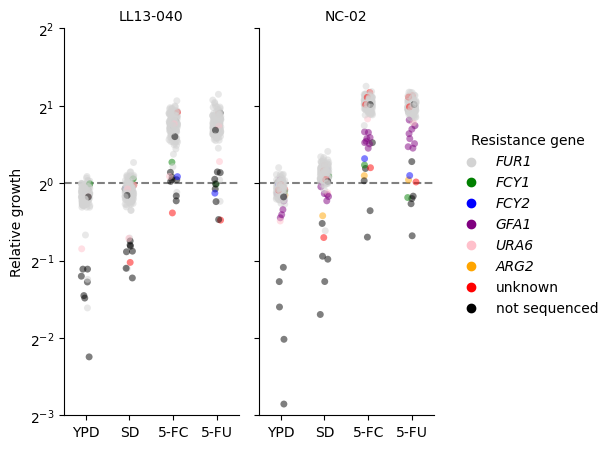

In [83]:
list_labels = ['FUR1', 'FCY1', 'FCY2', 'GFA1', 'URA6', 'ARG2', 'unknown', 'not sequenced']
fig = sns.catplot(data=fitness_df[~fitness_df.genotype.isin(['wt', 'pre'])], x='condition', y='rel_fit',
                  hue='Resistance_gene',
                  hue_order=list_labels, palette=['lightgrey', 'green', 'blue', 'purple', 'pink', 'orange', 'red', 'black'],
                  col='strain', col_order=['LL13-040','NC-02'],
                  alpha=.5, kind='strip', legend_out=False,
                  height=4.6, aspect=0.5 # height*aspect = width of EACH facet
                 )

fig.map(plt.axhline, y=1, ls='--', c='grey')
plt.yscale('log',base=2)
fig.set(ylim=(0.125,4))
fig.set_xticklabels(['YPD','SD','5-FC','5-FU'])
fig.set_axis_labels('', 'Relative growth')
fig.set_titles(col_template='{col_name}')
fig._legend.set_title('Resistance gene')
for i, v in enumerate(list_labels[:-2]):
    fig._legend.texts[i].set_fontstyle('italic')

#fig.fig.subplots_adjust(top=0.92)
#fig.fig.suptitle('Relative fitness at 30°C')
fig.tight_layout()
plt.savefig(graph_outpath+'20230413_resistance_gene_relfit.png', format='png', dpi=300)
plt.savefig(graph_outpath+'20230413_resistance_gene_relfit.svg', format='svg', dpi=300)

In [107]:
# This spreadsheet was obtained manually by:
# 1- looking up the mutations corresponding to SNPs identified in URA6, ARG2 and GFA1
# 2- Combining "cause_identied_df" with "unique_snp_wide"
# 3- Correcting "Sanger" value by replacing 0 with NaN whenever the gene was not sequenced by Sanger for the particular sample
cause_id_mut = pd.read_excel('df/cause_identified_df_withMutations.xlsx')
cause_id_mut

,background,RA_well,Resistance_gene,mutation_type,mutID_true,mutation,Sanger,gatk,samtools
0,LL13-040,N10,URA6,SNP,chrXI:392987:G/T:SNP,R52S,NaN,1,1
1,LL13-040,O2,URA6,SNP,chrXI:392987:G/T:SNP,R52S,NaN,1,1
2,NC-02,B16,ARG2,SNP,chrX:306468:A/T:SNP,K113*,NaN,1,1
3,NC-02,D21,GFA1,SNP,chrXI:243942:C/A:SNP,V478F,NaN,0,1
4,NC-02,F22,GFA1,SNP,chrXI:243886:G/T:SNP,N496K,NaN,1,1
...,...,...,...,...,...,...,...,...,...
269,LL13-040,O3,FUR1,SNP,chrVIII:362442:A/G:SNP,R110G,1.0,0,1
270,LL13-040,O4,FUR1,SNP,chrVIII:362442:A/G:SNP,R110G,1.0,0,1
271,LL13-040,O5,FUR1,SNP,chrVIII:362442:A/G:SNP,R110G,1.0,0,1
272,LL13-040,O8,FUR1,SNP,chrVIII:362380:C/T:SNP,S89L,1.0,1,1


In [150]:
fitmut = fitness_df.merge(right=cause_id_mut[['RA_well','Resistance_gene','mutation']], on=['RA_well','Resistance_gene'])
fitmut

,plate_number,RA_well,auc,rearray_plate_nb,condition,mutant_plate,96_well,strain,fluc_assay,pre_culture,...,genotype,FCY1_genotype,FUR1_genotype,respiration,key,Genomix_plate_nb,Genomix_plate_well,rel_fit,Resistance_gene,mutation
0,1,B10,14701.125,1,YPD,5,A3,LL13-040,5.0,3.0,...,mutant,NaN,NaN,True,113,1.0,A11,0.974173,FUR1,Q17*
1,2,B10,10836.625,1,SD,5,A3,LL13-040,5.0,3.0,...,mutant,NaN,NaN,True,113,1.0,A11,0.958061,FUR1,Q17*
2,3,B10,13931.625,1,5-FC,5,A3,LL13-040,5.0,3.0,...,mutant,NaN,NaN,True,113,1.0,A11,1.954321,FUR1,Q17*
3,4,B10,9752.000,1,5-FU,5,A3,LL13-040,5.0,3.0,...,mutant,NaN,NaN,True,113,1.0,A11,1.870618,FUR1,Q17*
4,1,B11,12602.375,1,YPD,5,E5,LL13-040,5.0,4.0,...,mutant,NaN,NaN,True,127,2.0,A7,0.835099,FUR1,L21del
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,4,O8,8936.875,1,5-FU,2,B10,LL13-040,4.0,3.0,...,mutant,NaN,NaN,True,98,1.0,D8,1.714262,FUR1,S89L
1092,1,O9,13071.000,1,YPD,5,B2,LL13-040,5.0,2.0,...,mutant,NaN,NaN,True,112,1.0,D10,0.866153,FUR1,Q17*
1093,2,O9,10250.375,1,SD,5,B2,LL13-040,5.0,2.0,...,mutant,NaN,NaN,True,112,1.0,D10,0.906231,FUR1,Q17*
1094,3,O9,11339.000,1,5-FC,5,B2,LL13-040,5.0,2.0,...,mutant,NaN,NaN,True,112,1.0,D10,1.590629,FUR1,Q17*


In [151]:
# Get min - max - median relative fitness for each mutation
fit_per_mut = fitmut.groupby(['Resistance_gene','condition','mutation','RA_well'])[['rel_fit']].first().reset_index()
statsfit_per_mut = fit_per_mut.groupby(['Resistance_gene','mutation','condition']).agg(Nstrains = ('RA_well', 'nunique'),
                                                                                       min_fit = ('rel_fit', 'min'),
                                                                                       max_fit = ('rel_fit', 'max'),
                                                                                       median_fit = ('rel_fit', 'median')
                                                                                      ).reset_index()
statsfit_per_mut.sort_values(by=['Resistance_gene','mutation','condition'], inplace=True)
statsfit_per_mut['temperature'] = 30
statsfit_per_mut

,Resistance_gene,mutation,condition,Nstrains,min_fit,max_fit,median_fit,temperature
0,ARG2,K113*,5-FC,1,1.069206,1.069206,1.069206,30
1,ARG2,K113*,5-FU,1,1.029178,1.029178,1.029178,30
2,ARG2,K113*,SD,1,0.746368,0.746368,0.746368,30
3,ARG2,K113*,YPD,1,0.896400,0.896400,0.896400,30
4,FUR1,A115ins,5-FC,4,2.000616,2.213276,2.058163,30
...,...,...,...,...,...,...,...,...
491,URA6,G73S,YPD,1,0.712347,0.712347,0.712347,30
492,URA6,R52S,5-FC,2,1.061723,1.700591,1.381157,30
493,URA6,R52S,5-FU,2,1.212967,1.664269,1.438618,30
494,URA6,R52S,SD,2,0.609517,0.949242,0.779380,30


In [152]:
statsfit_per_mut.to_excel('df/statsfit30_per_mut.xlsx')

In [153]:
# Quickly checking fitness in other conditions (echinocandins, etc)
fitness_df = pd.read_excel(fitness37_data, index_col=0) # Fitness so only rearrayed mutants and controls
fitness_df.loc[fitness_df.genotype == 'FCY1', 'Resistance_gene'] = 'FCY1'
fitness_df.loc[fitness_df.genotype == 'FCY2', 'Resistance_gene'] = 'FCY2'
fitness_df.loc[fitness_df.RA_well.isin(mutants_not_seq), 'Resistance_gene'] = 'not sequenced'
fitness_df.loc[fitness_df.RA_well.isin(unk_cause_of_res), 'Resistance_gene'] = 'unknown'
for g in candidate_genes+['FUR1']:
    fitness_df.loc[fitness_df.RA_well.isin(cause_identified_dict[g]), 'Resistance_gene'] = g
fitness_df

,plate_number,RA_well,auc,rearray_plate_nb,condition,mutant_plate,96_well,strain,fluc_assay,pre_culture,fluc_mutant,genotype,FCY1_genotype,FUR1_genotype,respiration,key,Genomix_plate_nb,Genomix_plate_well,rel_fit,Resistance_gene
0,1,B10,19964.125,1,YPD,5,A3,LL13-040,5.0,3.0,2.0,mutant,NaN,NaN,True,113,1.0,A11,0.926485,FUR1
1,2,B10,13022.375,1,SD,5,A3,LL13-040,5.0,3.0,2.0,mutant,NaN,NaN,True,113,1.0,A11,0.993439,FUR1
2,3,B10,18286.875,1,5-FC,5,A3,LL13-040,5.0,3.0,2.0,mutant,NaN,NaN,True,113,1.0,A11,2.226848,FUR1
3,4,B10,7054.500,1,Mica_low,5,A3,LL13-040,5.0,3.0,2.0,mutant,NaN,NaN,True,113,1.0,A11,0.822359,FUR1
4,5,B10,4436.375,1,Mica_mid,5,A3,LL13-040,5.0,3.0,2.0,mutant,NaN,NaN,True,113,1.0,A11,0.852268,FUR1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4615,11,O9,2543.125,1,Nystatin_mid,5,B2,LL13-040,5.0,2.0,2.0,mutant,NaN,NaN,True,112,1.0,D10,0.795161,FUR1
4616,12,O9,2168.625,1,Nystatin_high,5,B2,LL13-040,5.0,2.0,2.0,mutant,NaN,NaN,True,112,1.0,D10,0.857037,FUR1
4617,13,O9,7997.375,1,Fluco_low,5,B2,LL13-040,5.0,2.0,2.0,mutant,NaN,NaN,True,112,1.0,D10,0.748249,FUR1
4618,14,O9,6127.375,1,Fluco_mid,5,B2,LL13-040,5.0,2.0,2.0,mutant,NaN,NaN,True,112,1.0,D10,0.766149,FUR1


In [154]:
fitmut = fitness_df.merge(right=cause_id_mut[['RA_well','Resistance_gene','mutation']], on=['RA_well','Resistance_gene'])
fitmut

,plate_number,RA_well,auc,rearray_plate_nb,condition,mutant_plate,96_well,strain,fluc_assay,pre_culture,...,genotype,FCY1_genotype,FUR1_genotype,respiration,key,Genomix_plate_nb,Genomix_plate_well,rel_fit,Resistance_gene,mutation
0,1,B10,19964.125,1,YPD,5,A3,LL13-040,5.0,3.0,...,mutant,NaN,NaN,True,113,1.0,A11,0.926485,FUR1,Q17*
1,2,B10,13022.375,1,SD,5,A3,LL13-040,5.0,3.0,...,mutant,NaN,NaN,True,113,1.0,A11,0.993439,FUR1,Q17*
2,3,B10,18286.875,1,5-FC,5,A3,LL13-040,5.0,3.0,...,mutant,NaN,NaN,True,113,1.0,A11,2.226848,FUR1,Q17*
3,4,B10,7054.500,1,Mica_low,5,A3,LL13-040,5.0,3.0,...,mutant,NaN,NaN,True,113,1.0,A11,0.822359,FUR1,Q17*
4,5,B10,4436.375,1,Mica_mid,5,A3,LL13-040,5.0,3.0,...,mutant,NaN,NaN,True,113,1.0,A11,0.852268,FUR1,Q17*
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4105,11,O9,2543.125,1,Nystatin_mid,5,B2,LL13-040,5.0,2.0,...,mutant,NaN,NaN,True,112,1.0,D10,0.795161,FUR1,Q17*
4106,12,O9,2168.625,1,Nystatin_high,5,B2,LL13-040,5.0,2.0,...,mutant,NaN,NaN,True,112,1.0,D10,0.857037,FUR1,Q17*
4107,13,O9,7997.375,1,Fluco_low,5,B2,LL13-040,5.0,2.0,...,mutant,NaN,NaN,True,112,1.0,D10,0.748249,FUR1,Q17*
4108,14,O9,6127.375,1,Fluco_mid,5,B2,LL13-040,5.0,2.0,...,mutant,NaN,NaN,True,112,1.0,D10,0.766149,FUR1,Q17*


In [155]:
# Get min - max - median relative fitness for each mutation
fit_per_mut = fitmut.groupby(['Resistance_gene','condition','mutation','RA_well'])[['rel_fit']].first().reset_index()
statsfit_per_mut = fit_per_mut.groupby(['Resistance_gene','mutation','condition']).agg(Nstrains = ('RA_well', 'nunique'),
                                                                                       min_fit = ('rel_fit', 'min'),
                                                                                       max_fit = ('rel_fit', 'max'),
                                                                                       median_fit = ('rel_fit', 'median')
                                                                                      ).reset_index()
statsfit_per_mut.sort_values(by=['Resistance_gene','mutation','condition'], inplace=True)
statsfit_per_mut['temperature'] = 37
statsfit_per_mut

,Resistance_gene,mutation,condition,Nstrains,min_fit,max_fit,median_fit,temperature
0,ARG2,K113*,5-FC,1,1.040038,1.040038,1.040038,37
1,ARG2,K113*,Caspo_high,1,0.732269,0.732269,0.732269,37
2,ARG2,K113*,Caspo_low,1,0.638062,0.638062,0.638062,37
3,ARG2,K113*,Caspo_mid,1,0.759232,0.759232,0.759232,37
4,ARG2,K113*,Fluco_high,1,0.750671,0.750671,0.750671,37
...,...,...,...,...,...,...,...,...
1855,URA6,R52S,Nystatin_high,2,0.568690,0.904411,0.736551,37
1856,URA6,R52S,Nystatin_low,2,0.404674,0.840908,0.622791,37
1857,URA6,R52S,Nystatin_mid,2,0.453842,0.855624,0.654733,37
1858,URA6,R52S,SD,2,0.624086,0.887524,0.755805,37


In [156]:
statsfit_per_mut.to_excel('df/statsfit37_per_mut.xlsx')

In [157]:
# Compile relative fitness per mutation and add concentrations of compounds
statsfit30 = pd.read_excel('df/statsfit30_per_mut.xlsx', index_col=0)
statsfit37 = pd.read_excel('df/statsfit37_per_mut.xlsx', index_col=0)
statsfit = pd.concat([statsfit30, statsfit37], ignore_index=True)
statsfit.sort_values(by=['Resistance_gene','mutation', 'condition'], inplace=True)
statsfit.reset_index(inplace=True, drop=True)
statsfit

,Resistance_gene,mutation,condition,Nstrains,min_fit,max_fit,median_fit,temperature
0,ARG2,K113*,5-FC,1,1.069206,1.069206,1.069206,30
1,ARG2,K113*,5-FC,1,1.040038,1.040038,1.040038,37
2,ARG2,K113*,5-FU,1,1.029178,1.029178,1.029178,30
3,ARG2,K113*,Caspo_high,1,0.732269,0.732269,0.732269,37
4,ARG2,K113*,Caspo_low,1,0.638062,0.638062,0.638062,37
...,...,...,...,...,...,...,...,...
2351,URA6,R52S,Nystatin_mid,2,0.453842,0.855624,0.654733,37
2352,URA6,R52S,SD,2,0.609517,0.949242,0.779380,30
2353,URA6,R52S,SD,2,0.624086,0.887524,0.755805,37
2354,URA6,R52S,YPD,2,0.555037,0.886314,0.720676,30


In [160]:
concentration_dic = {30:{'YPD':'','SD':'',
                         '5-FC': 25,'5-FU': 6.25},
                     37:{'YPD':'','SD':'',
                         '5-FC': 25,
                        'Caspo_low':0.25,'Caspo_mid':1,'Caspo_high':2,
                        'Mica_low':0.0625,'Mica_mid':0.25,'Mica_high':0.5,
                        'Nystatin_low':4,'Nystatin_mid':8,'Nystatin_high':16,
                        'Fluco_low':16,'Fluco_mid':32,'Fluco_high':64}}

In [161]:
statsfit['concentration'] = statsfit.apply(lambda row: concentration_dic[row.temperature][row.condition], axis=1)
statsfit

,Resistance_gene,mutation,condition,Nstrains,min_fit,max_fit,median_fit,temperature,concentration
0,ARG2,K113*,5-FC,1,1.069206,1.069206,1.069206,30,25
1,ARG2,K113*,5-FC,1,1.040038,1.040038,1.040038,37,25
2,ARG2,K113*,5-FU,1,1.029178,1.029178,1.029178,30,6.25
3,ARG2,K113*,Caspo_high,1,0.732269,0.732269,0.732269,37,2
4,ARG2,K113*,Caspo_low,1,0.638062,0.638062,0.638062,37,0.25
...,...,...,...,...,...,...,...,...,...
2351,URA6,R52S,Nystatin_mid,2,0.453842,0.855624,0.654733,37,8
2352,URA6,R52S,SD,2,0.609517,0.949242,0.779380,30,
2353,URA6,R52S,SD,2,0.624086,0.887524,0.755805,37,
2354,URA6,R52S,YPD,2,0.555037,0.886314,0.720676,30,


In [162]:
statsfit.to_excel('df/statsfit.xlsx')

## FUR1 - samtools vs gatk vs Sanger

### Correlation with preculture

In [108]:
annotwide[annotwide.RA_well.isin(['M15', 'I10', 'L16'])]
# Just to show that, in rare cases, 2 SNPs can lead to the same aminoacid substitution
# But because we groupby preculture below, if the distinct SNPs appeared in different precultures, we won't see it propagate in the cumulated number of SNPs (per preculture)

,RA_well,pos_nt,SNP_pos_aa,strain,fluc_assay,pre_culture,genotype,mutID_true,mutation_type,mutation,Sanger,gatk,samtools
131,I10,624.0,209.0,LL13-040,5.0,4.0,mutant,chrVIII:362739:T/C:SNP,SNP,F209L,1,0,1
194,L16,147.0,50.0,NC-02,4.0,1.0,mutant,chrVIII:362262:G/T:SNP,SNP,G50Y,1,0,1
195,L16,148.0,50.0,NC-02,4.0,1.0,mutant,chrVIII:362263:G/A:SNP,SNP,G50Y,1,0,1
214,M15,626.0,209.0,NC-02,3.0,3.0,mutant,chrVIII:362741:T/A:SNP,SNP,F209L,1,1,1


In [109]:
by_preculture = annotwide.groupby(['strain', 'fluc_assay', 'pre_culture']).agg(Nsamples = ('RA_well', 'nunique'),
                                                                               Nmut_type = ('mutation_type', 'nunique'),
                                                                               Nsnps = ('mutID_true', 'nunique'), # Cumulated number of genotypes (sometimes 2 indels in the same FUR1 seq)
                                                                               Nmut = ('mutation', 'nunique') # Cumulated number of mutations (sometimes 2 indels in the same FUR1 seq)
                                                                              ).reset_index().reset_index()
by_preculture

,index,strain,fluc_assay,pre_culture,Nsamples,Nmut_type,Nsnps,Nmut
0,0,LL13-040,1.0,1.0,5,2,3,3
1,1,LL13-040,2.0,1.0,4,1,4,4
2,2,LL13-040,3.0,1.0,5,2,5,5
3,3,LL13-040,3.0,2.0,4,1,3,3
4,4,LL13-040,3.0,3.0,41,1,3,3
5,5,LL13-040,4.0,1.0,16,2,5,5
6,6,LL13-040,4.0,2.0,11,1,9,9
7,7,LL13-040,4.0,3.0,7,1,7,7
8,8,LL13-040,4.0,4.0,3,1,3,3
9,9,LL13-040,5.0,1.0,5,1,5,5


In [110]:
annotwide[(annotwide.fluc_assay == 4) & (annotwide.pre_culture==1) & (annotwide.strain=='NC-02')]

,RA_well,pos_nt,SNP_pos_aa,strain,fluc_assay,pre_culture,genotype,mutID_true,mutation_type,mutation,Sanger,gatk,samtools
6,B17,549.0,184.0,NC-02,4.0,1.0,mutant,chrVIII:362664:G/T:SNP,SNP,E184*,1,0,1
27,C17,513.0,171.0,NC-02,4.0,1.0,mutant,chrVIII:362627:T/TA:indel,indel,S171ins,1,0,0
156,J16,148.0,50.0,NC-02,4.0,1.0,mutant,chrVIII:362263:G/A:SNP,SNP,G50D,1,1,1
174,K16,272.0,91.0,NC-02,4.0,1.0,mutant,chrVIII:362387:G/T:SNP,SNP,E91D,0,0,1
194,L16,147.0,50.0,NC-02,4.0,1.0,mutant,chrVIII:362262:G/T:SNP,SNP,G50Y,1,0,1
195,L16,148.0,50.0,NC-02,4.0,1.0,mutant,chrVIII:362263:G/A:SNP,SNP,G50Y,1,0,1
215,M16,2.0,1.0,NC-02,4.0,1.0,mutant,chrVIII:362117:G/T:SNP,SNP,M1I,1,1,1
233,N16,633.0,212.0,NC-02,4.0,1.0,mutant,chrVIII:362748:A/T:SNP,SNP,R212*,1,1,1


In [115]:
pie_data = annotwide[(annotwide.fluc_assay == 3) & (annotwide.pre_culture==3) & (annotwide.strain=='LL13-040')].groupby('mutation').size().reset_index(name='Nsamples')
pie_data

,mutation,Nsamples
0,G104S,1
1,G210D,1
2,R110G,39


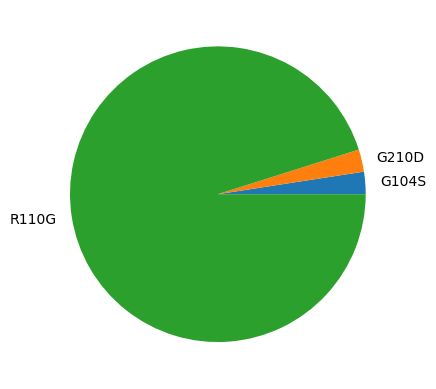

In [121]:
plt.pie(pie_data.Nsamples, labels=pie_data.mutation)
plt.savefig(graph_outpath + '20230328_Nmut_preculture_pie.svg', format='svg', dpi=300)

C:\Users\duran\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\seaborn\utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


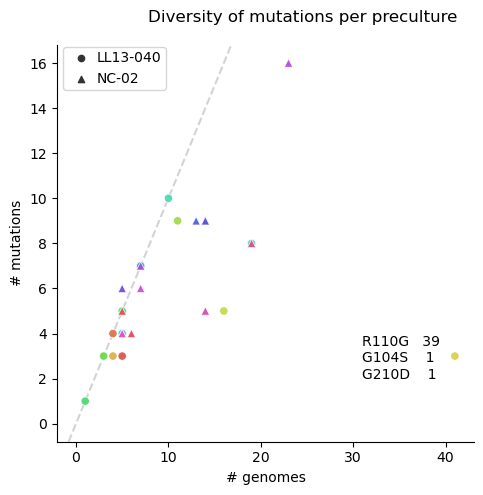

In [111]:
fig = sns.relplot(data=by_preculture, x='Nsamples', y='Nmut',
            hue='index', palette='hls',
            style='strain', markers = ['o', '^']
           )

fig.axes[0][0].axline((0,0), (1,1), ls='--', c='lightgrey', zorder=0)
fig.set_axis_labels('# genomes', '# mutations')

handles, labels = fig.axes[0][0].get_legend_handles_labels()
sns.move_legend(fig, bbox_to_anchor=(0.1, 0.92), loc='upper left', title=None, frameon=True, handles=handles[-2:], labels=labels[-2:], markerscale=0.75, handletextpad=0.1, borderpad=0.3)

fig.axes[0][0].annotate('R110G'+'39'.rjust(5)+
                        '\nG104S'+'1'.rjust(5)+
                        '\nG210D'+'1'.rjust(5),
                       (31,2))
                        
fig.fig.subplots_adjust(top=0.92)
fig.fig.suptitle('Diversity of mutations per preculture')
fig.tight_layout()
plt.savefig(graph_outpath + '20230322_Nmut_preculture.svg', format='svg', dpi=300)

### UpSet plots

In [53]:
bymut = annotwide.groupby(['strain', 'mutation']).agg(Nsamples = ('RA_well', 'nunique'),
                                                      Nsnps = ('mutID_true', 'nunique'), # Won't be different from 1 if synonymous mutation arose in a different background
                                                      mut = ('mutation_type', 'first'), # Replace 'unique' by 'first' if only 1 value
                                                      Sanger = ('Sanger', 'max'), gatk = ('gatk', 'max'), samtools = ('samtools', 'max'))
bymut

Nsamples  Nsnps    mut  Sanger  gatk  samtools
strain   mutation                                                
LL13-040 A146D            1      1    SNP       0     0         1
         A146del          1      1  indel       1     1         0
         A149P            1      1    SNP       0     1         1
         A86T             2      1    SNP       1     1         1
         A86V             2      1    SNP       1     1         1
...                     ...    ...    ...     ...   ...       ...
NC-02    V84A             1      1    SNP       1     0         1
         V84F             1      1    SNP       1     0         1
         WT              10      1   none       1     0         0
         Y121H            3      1    SNP       1     1         1
         Y214H           12      1    SNP       1     1         1

[134 rows x 6 columns]

In [54]:
bymut[bymut.Nsnps != 1 ] # G50Y special case with two SNPs in the same codon

,,Nsamples,Nsnps,mut,Sanger,gatk,samtools
strain,mutation,,,,,,
NC-02,G50Y,1,2,SNP,1,0,1


In [55]:
mut_sorting_dict = {'SNP':0, 'indel':1, 'none':2}
mut_ind = bymut.sort_values(by=['strain','Nsamples'], ascending=[True,False]).astype({'gatk': bool, 'samtools': bool, 'Sanger': bool}).reset_index()
#mut_ind = bymut.sort_values(by=['mut'], key=lambda x: x.map(mut_sorting_dict)).astype({'gatk': bool, 'samtools': bool, 'Sanger': bool})
mut_ind

,strain,mutation,Nsamples,Nsnps,mut,Sanger,gatk,samtools
0,LL13-040,R110G,39,1,SNP,True,True,True
1,LL13-040,V81D,13,1,SNP,True,True,True
2,LL13-040,G207S,12,1,SNP,True,False,True
3,LL13-040,Q17*,5,1,SNP,True,True,True
4,LL13-040,S145N,3,1,SNP,True,True,True
...,...,...,...,...,...,...,...,...
129,NC-02,S89del,1,1,indel,True,True,False
130,NC-02,V47del,1,1,indel,True,True,False
131,NC-02,V81F,1,1,SNP,True,True,True
132,NC-02,V84A,1,1,SNP,True,False,True


In [56]:
#mut_ind.to_excel(Sanger_list_mutations[:-5]+'_merged.xlsx')

In [57]:
len(mut_ind[mut_ind.mutation != 'WT'].mutation.unique())

117

In [58]:
Lmax = mut_ind[mut_ind.strain == 'LL13-040'].Nsamples.max()
Lmaxlabel = mut_ind.loc[(mut_ind.Nsamples == Lmax) & (mut_ind.strain == 'LL13-040'), 'mutation'].values[0]
print(Lmax, Lmaxlabel)

39 R110G


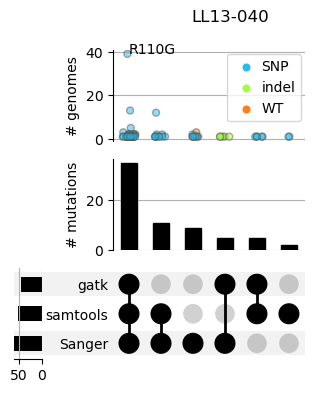

In [61]:
fig = plt.figure(figsize=(3.75, 4.02))
mut_upset = UpSet(from_indicators(['gatk','samtools','Sanger'], data=mut_ind[mut_ind.strain == 'LL13-040']),
                  sort_by='cardinality',
                  element_size=None,
                  intersection_plot_elements=3, # height of intersection barplot in matrix elements
                  totals_plot_elements = 1 # width of totals barplot in matrix elements
                 )

mut_upset.add_catplot(value='Nsamples', kind='strip',
                      hue='mut', hue_order=list(mut_sorting_dict), palette='turbo',
                      alpha=.5, linewidth=1, jitter=0.2)

d = mut_upset.plot(fig=fig) # Assigns all plots to a dictionary containing axes subplots - same keys as gridspec returned by mut_upset.make_grid()
ax_int = d['intersections'] # Key corresponding to intersection barplot
ax = d['extra1'] # Key corresponding to additional plot, in this case catplot
ax_int.set_ylabel('# mutations')
ax.set(ylabel = (0,None))
ax.set_ylabel('# genomes')
ax.annotate(Lmaxlabel, (0,Lmax))

handles, labels = ax.get_legend_handles_labels()
labels[2] = 'WT'
ax.legend(bbox_to_anchor=(1,1), markerscale=0.8, handletextpad=0.1, borderaxespad=0.3, handles=handles, labels=labels)

plt.suptitle('LL13-040', x=0.7)

plt.savefig(graph_outpath + '20230417_upsetplot_FUR1_LL13.svg', format='svg', dpi=300)

In [62]:
Nmax = mut_ind[mut_ind.strain == 'NC-02'].Nsamples.max()
Nmaxlabel = mut_ind.loc[(mut_ind.Nsamples == Nmax) & (mut_ind.strain == 'NC-02'), 'mutation'].values[0]
print(Nmax, Nmaxlabel)

12 Y214H


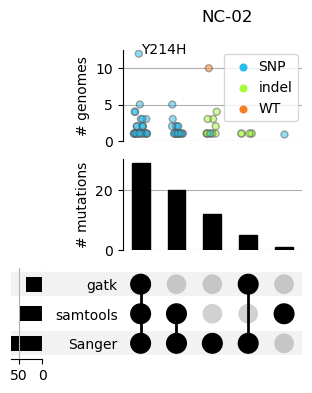

In [63]:
fig = plt.figure(figsize=(3.75, 4.02))
mut_upset = UpSet(from_indicators(['gatk','samtools','Sanger'], data=mut_ind[mut_ind.strain == 'NC-02']),
                  sort_by='cardinality',
                  element_size=None,
                  intersection_plot_elements=3, # height of intersection barplot in matrix elements
                  totals_plot_elements = 1 # width of totals barplot in matrix elements
                 )

mut_upset.add_catplot(value='Nsamples', kind='strip',
                      hue='mut', hue_order=list(mut_sorting_dict), palette='turbo',
                      alpha=.5, linewidth=1, jitter=0.2)

d = mut_upset.plot(fig=fig) # Assigns all plots to a dictionary containing axes subplots - same keys as gridspec returned by mut_upset.make_grid()
ax_int = d['intersections'] # Key corresponding to intersection barplot
ax = d['extra1'] # Key corresponding to additional plot, in this case catplot
ax_int.set_ylabel('# mutations')
ax.set(ylim = (0,None))
ax.set_ylabel('# genomes')
ax.annotate(Nmaxlabel, (0,Nmax))

handles, labels = ax.get_legend_handles_labels()
labels[2] = 'WT'
ax.legend(bbox_to_anchor=(1,1), markerscale=0.8, handletextpad=0.1, borderaxespad=0.3, handles=handles, labels=labels)

plt.suptitle('NC-02', x=0.7)
plt.savefig(graph_outpath + '20230417_upsetplot_FUR1_NC-02.svg', format='svg', dpi=300)

### Compare to all mutations affecting stability (mutfunc prediction)

For the steps below, we use the unique_snp_wide dataframe, which does not include genomes carrying the WT allele of FUR1

In [9]:
unique_snp_wide = pd.read_excel('df/unique_snp_wide.xlsx', index_col=0)
unique_snp_wide

detected_by,RA_well,pos_nt,SNP_pos_aa,strain,fluc_assay,pre_culture,genotype,mutID_true,mutation_type,mutation,Sanger,gatk,samtools
0,B10,48.0,17.0,LL13-040,5.0,3.0,mutant,chrVIII:362163:C/T:SNP,SNP,Q17*,1,1,1
1,B11,62.0,21.0,LL13-040,5.0,4.0,mutant,chrVIII:362176:TG/T:indel,indel,L21del,1,1,0
2,B12,618.0,207.0,LL13-040,6.0,3.0,mutant,chrVIII:362733:G/A:SNP,SNP,G207S,1,0,1
3,B13,611.0,204.0,LL13-040,6.0,5.0,mutant,chrVIII:362725:CA/C:indel,indel,P204del,1,1,0
4,B14,415.0,139.0,NC-02,2.0,1.0,mutant,chrVIII:362530:T/A:SNP,SNP,M139K,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,O3,327.0,110.0,LL13-040,3.0,3.0,mutant,chrVIII:362442:A/G:SNP,SNP,R110G,1,0,1
258,O4,327.0,110.0,LL13-040,3.0,3.0,mutant,chrVIII:362442:A/G:SNP,SNP,R110G,1,0,1
259,O5,327.0,110.0,LL13-040,3.0,3.0,mutant,chrVIII:362442:A/G:SNP,SNP,R110G,1,0,1
260,O8,265.0,89.0,LL13-040,4.0,3.0,mutant,chrVIII:362380:C/T:SNP,SNP,S89L,1,1,1


In [11]:
# Number of missense substitutions captured in our dataset
tot_dataset = len([x for x in unique_snp_wide[unique_snp_wide.mutation_type == 'SNP'].mutation.unique() if x[-1] != '*'])
tot_dataset

76

In [12]:
mutfunc_stability_mutations = pd.read_csv(mutfunc_stab_path, sep='\t', comment='#', header=0)
mutfunc_stability_mutations['mutation'] = mutfunc_stability_mutations[['posaa','refaa','altaa']].dropna().apply(lambda row: row.refaa+str(int(row.posaa))+row.altaa, axis=1)
mutfunc_stability_mutations['captured'] = mutfunc_stability_mutations.mutation.apply(lambda x: True if x in unique_snp_wide.mutation.unique() else False) 
mutfunc_stability_mutations

,chr,pos,ref,alt,gene,posaa,refaa,altaa,impact,pdb_id,chain,pdb_position,ddg,evidence,mutation,captured
0,-,-,-,-,YHR128W,6,F,I,1,4ccde29198ac5f95725c584f1bfc14e5_1bd3,A,6,2.70178,hom,F6I,False
1,-,-,-,-,YHR128W,6,F,V,1,4ccde29198ac5f95725c584f1bfc14e5_1bd3,A,6,2.81548,hom,F6V,False
2,-,-,-,-,YHR128W,6,F,S,1,4ccde29198ac5f95725c584f1bfc14e5_1bd3,A,6,4.09852,hom,F6S,False
3,-,-,-,-,YHR128W,6,F,P,1,4ccde29198ac5f95725c584f1bfc14e5_1bd3,A,6,3.89350,hom,F6P,False
4,-,-,-,-,YHR128W,6,F,T,1,4ccde29198ac5f95725c584f1bfc14e5_1bd3,A,6,3.80152,hom,F6T,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274,-,-,-,-,YHR128W,215,C,P,1,4ccde29198ac5f95725c584f1bfc14e5_1bd3,A,215,5.24768,hom,C215P,False
1275,-,-,-,-,YHR128W,215,C,Y,1,4ccde29198ac5f95725c584f1bfc14e5_1bd3,A,215,2.00146,hom,C215Y,False
1276,-,-,-,-,YHR128W,215,C,H,1,4ccde29198ac5f95725c584f1bfc14e5_1bd3,A,215,2.03602,hom,C215H,False
1277,-,-,-,-,YHR128W,215,C,D,1,4ccde29198ac5f95725c584f1bfc14e5_1bd3,A,215,2.52432,hom,C215D,False


In [13]:
# saturating ddG >5
mutfunc_stability_mutations['sat_ddG'] = mutfunc_stability_mutations.ddg.apply(lambda x: 5 if x > 5 else x)
mutfunc_stability_mutations

,chr,pos,ref,alt,gene,posaa,refaa,altaa,impact,pdb_id,chain,pdb_position,ddg,evidence,mutation,captured,sat_ddG
0,-,-,-,-,YHR128W,6,F,I,1,4ccde29198ac5f95725c584f1bfc14e5_1bd3,A,6,2.70178,hom,F6I,False,2.70178
1,-,-,-,-,YHR128W,6,F,V,1,4ccde29198ac5f95725c584f1bfc14e5_1bd3,A,6,2.81548,hom,F6V,False,2.81548
2,-,-,-,-,YHR128W,6,F,S,1,4ccde29198ac5f95725c584f1bfc14e5_1bd3,A,6,4.09852,hom,F6S,False,4.09852
3,-,-,-,-,YHR128W,6,F,P,1,4ccde29198ac5f95725c584f1bfc14e5_1bd3,A,6,3.89350,hom,F6P,False,3.89350
4,-,-,-,-,YHR128W,6,F,T,1,4ccde29198ac5f95725c584f1bfc14e5_1bd3,A,6,3.80152,hom,F6T,False,3.80152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274,-,-,-,-,YHR128W,215,C,P,1,4ccde29198ac5f95725c584f1bfc14e5_1bd3,A,215,5.24768,hom,C215P,False,5.00000
1275,-,-,-,-,YHR128W,215,C,Y,1,4ccde29198ac5f95725c584f1bfc14e5_1bd3,A,215,2.00146,hom,C215Y,False,2.00146
1276,-,-,-,-,YHR128W,215,C,H,1,4ccde29198ac5f95725c584f1bfc14e5_1bd3,A,215,2.03602,hom,C215H,False,2.03602
1277,-,-,-,-,YHR128W,215,C,D,1,4ccde29198ac5f95725c584f1bfc14e5_1bd3,A,215,2.52432,hom,C215D,False,2.52432


In [23]:
stab_impact_mut = mutfunc_stability_mutations.groupby('captured').size().to_frame(name='impactful').sort_values(by='captured', ascending=False)
stab_impact_mut['totals'] = [tot_dataset, 19*216 - tot_dataset]
stab_impact_mut['non impactful'] = stab_impact_mut['totals'] - stab_impact_mut['impactful']
stab_impact_mut = stab_impact_mut[['impactful', 'non impactful', 'totals']]
stab_impact_mut

,impactful,non impactful,totals
captured,,,
True,42,34,76
False,1237,2791,4028


In [29]:
# Fisher's exact test on contingency table
from scipy.stats import fisher_exact

res = fisher_exact(stab_impact_mut[['impactful', 'non impactful']].to_numpy())
res

SignificanceResult(statistic=2.787151077084027, pvalue=1.3890156280071492e-05)

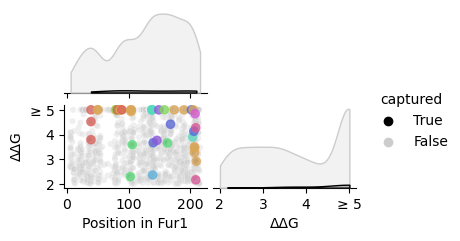

In [81]:
fig = sns.pairplot(mutfunc_stability_mutations, vars=['posaa','sat_ddG'],
                   hue='captured', hue_order=[True,False], palette=['k', '.8'],
                   corner=True, plot_kws=dict(marker="o", s=20, alpha=.3), diag_kws=dict(cut=0),
                   height=1.2, aspect=1.56 # height*aspect = width of EACH facet
                  )

clevels = mutfunc_stability_mutations[mutfunc_stability_mutations.captured].refaa.unique()
rgb_vals = sns.color_palette('hls', len(clevels))
color_map = dict(zip(clevels, rgb_vals))
fig.axes[1][0].scatter(data=mutfunc_stability_mutations[mutfunc_stability_mutations.captured],
                       x='posaa', y='sat_ddG',
                       c=mutfunc_stability_mutations[mutfunc_stability_mutations.captured].refaa.map(color_map),
                       alpha=.7
                      )
fig.axes[1][0].set(xlabel='Position in Fur1', ylabel=u'ΔΔG')
tick_txt = list(np.arange(2,6,1))
tick_txt[-1] = u'≥ 5'
fig.axes[1][0].yaxis.set_ticks(ticks=np.arange(2,6,1), labels=tick_txt)
fig.axes[1][0].set(ylim=(None,5.2))
fig.axes[1][1].set(xlabel=u'ΔΔG')
fig.axes[1][1].xaxis.set_ticks(ticks=np.arange(2,6,1), labels=tick_txt)
#fig.fig.subplots_adjust(top=0.92)
#fig.fig.suptitle('Mutations affecting stability in Fur1')
fig.tight_layout()
plt.savefig(graph_outpath + '/20230417_mutfunc_stability.svg', format='svg', dpi=300)
plt.savefig(graph_outpath + '/20230417_mutfunc_stability.png', format='png', dpi=300)

### Compare to all mutations affecting conservation (mutfunc prediction)

In [30]:
mutfunc_conservation_mutations = pd.read_csv(mutfunc_cons_path, sep='\t', comment='#', header=0)
mutfunc_conservation_mutations['mutation'] = mutfunc_conservation_mutations[['posaa','refaa','altaa']].dropna().apply(lambda row: row.refaa+str(int(row.posaa))+row.altaa, axis=1)
mutfunc_conservation_mutations['captured'] = mutfunc_conservation_mutations.mutation.apply(lambda x: True if x in unique_snp_wide.mutation.unique() else False) 
mutfunc_conservation_mutations

,chr,pos,ref,alt,gene,posaa,refaa,altaa,impact,score,ic,number_sequences,total_sequences,mutation,captured
0,-,-,-,-,YHR128W,3,S,W,1,0.025408,3.06550,10,68,S3W,False
1,-,-,-,-,YHR128W,4,E,F,1,0.033374,3.08841,20,68,E4F,False
2,-,-,-,-,YHR128W,4,E,M,1,0.034899,3.08841,20,68,E4M,False
3,-,-,-,-,YHR128W,4,E,Y,1,0.044565,3.08841,20,68,E4Y,False
4,-,-,-,-,YHR128W,4,E,C,1,0.016959,3.08841,20,68,E4C,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2662,-,-,-,-,YHR128W,216,V,E,1,0.001692,2.80697,57,68,V216E,False
2663,-,-,-,-,YHR128W,216,V,C,1,0.002171,2.80697,57,68,V216C,False
2664,-,-,-,-,YHR128W,216,V,W,1,0.000304,2.80697,57,68,V216W,False
2665,-,-,-,-,YHR128W,216,V,R,1,0.001060,2.80697,57,68,V216R,False


In [32]:
cons_impact_mut = mutfunc_conservation_mutations.groupby('captured').size().to_frame(name='impactful').sort_values(by='captured', ascending=False)
cons_impact_mut['totals'] = [tot_dataset, 19*216 - tot_dataset]
cons_impact_mut['non impactful'] = cons_impact_mut['totals'] - cons_impact_mut['impactful']
cons_impact_mut = cons_impact_mut[['impactful', 'non impactful', 'totals']]
cons_impact_mut

,impactful,non impactful,totals
captured,,,
True,67,9,76
False,2600,1428,4028


In [33]:
# Fisher's exact test on contingency table
from scipy.stats import fisher_exact

res = fisher_exact(cons_impact_mut[['impactful', 'non impactful']].to_numpy())
res

SignificanceResult(statistic=4.088717948717949, pvalue=4.955563351495201e-06)

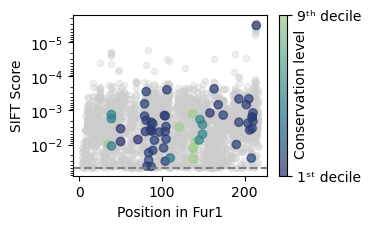

In [92]:
fig, ax = plt.subplots(figsize=(3.75, 2.4))

ax.scatter(data=mutfunc_conservation_mutations[~mutfunc_conservation_mutations.captured], x='posaa', y='score', color='.8', s=20, alpha=.3)
im = ax.scatter(data=mutfunc_conservation_mutations[mutfunc_conservation_mutations.captured], x='posaa', y='score',
                c=mutfunc_conservation_mutations[mutfunc_conservation_mutations.captured].ic, cmap = 'crest_r', alpha=.7,
                vmin=mutfunc_conservation_mutations.ic.quantile(0.1),
                vmax=mutfunc_conservation_mutations.ic.quantile(0.9)
               )
ax.invert_yaxis()
plt.yscale('log')

cbar = fig.colorbar(im, ax=ax)
cbar.set_ticks([mutfunc_conservation_mutations.ic.quantile(0.1), mutfunc_conservation_mutations.ic.quantile(0.9)], labels=['1ˢᵗ decile', '9ᵗʰ decile'])
ax.text(260,0.02, 'Conservation level', rotation=90)

plt.axhline(y=0.05, ls='--', c='grey')
ax.set_ylabel('SIFT Score')
ax.set_xlabel('Position in Fur1')

#plt.title('Mutations affecting conservation in Fur1')
fig.tight_layout()
plt.savefig(graph_outpath + '/20230417_mutfunc_conservation.svg', format='svg', dpi=300)
plt.savefig(graph_outpath + '/20230417_mutfunc_conservation.png', format='png', dpi=300)

### Plot mutations on FUR1 sequence

In [8]:
annot = pd.read_excel('df/annot.xlsx', index_col=0)
unique_snp_wide = pd.read_excel('df/unique_snp_wide.xlsx', index_col=0)

In [9]:
by_snp = unique_snp_wide.groupby(['mutID_true','pos_nt','SNP_pos_aa','mutation_type']).agg(Nsamples = ('RA_well', 'nunique'), strain = ('strain', 'unique'),
                                                                           Sanger = ('Sanger', 'max'), gatk = ('gatk', 'max'), samtools = ('samtools', 'max')).sort_values(by='pos_nt').reset_index()
by_snp

,mutID_true,pos_nt,SNP_pos_aa,mutation_type,Nsamples,strain,Sanger,gatk,samtools
0,chrVIII:362115:A/G:SNP,0,1,SNP,2,[NC-02],1,0,1
1,chrVIII:362115:A/T:SNP,0,1,SNP,1,[LL13-040],1,1,1
2,chrVIII:362116:T/A:SNP,1,1,SNP,1,[LL13-040],0,1,1
3,chrVIII:362116:T/C:SNP,1,1,SNP,1,[NC-02],1,1,1
4,chrVIII:362117:G/T:SNP,2,1,SNP,2,"[LL13-040, NC-02]",1,1,1
...,...,...,...,...,...,...,...,...,...
113,chrVIII:362743:G/A:SNP,628,210,SNP,1,[LL13-040],1,1,1
114,chrVIII:362743:G/T:SNP,628,210,SNP,4,"[NC-02, LL13-040]",1,1,1
115,chrVIII:362748:A/T:SNP,633,212,SNP,1,[NC-02],1,1,1
116,chrVIII:362753:C/A:SNP,638,213,SNP,1,[LL13-040],1,1,1


In [10]:
by_snp['strain_combinations'] = by_snp.strain.apply(lambda x: x[0] if len(x)==1 else 'both')
by_snp

,mutID_true,pos_nt,SNP_pos_aa,mutation_type,Nsamples,strain,Sanger,gatk,samtools,strain_combinations
0,chrVIII:362115:A/G:SNP,0,1,SNP,2,[NC-02],1,0,1,NC-02
1,chrVIII:362115:A/T:SNP,0,1,SNP,1,[LL13-040],1,1,1,LL13-040
2,chrVIII:362116:T/A:SNP,1,1,SNP,1,[LL13-040],0,1,1,LL13-040
3,chrVIII:362116:T/C:SNP,1,1,SNP,1,[NC-02],1,1,1,NC-02
4,chrVIII:362117:G/T:SNP,2,1,SNP,2,"[LL13-040, NC-02]",1,1,1,both
...,...,...,...,...,...,...,...,...,...,...
113,chrVIII:362743:G/A:SNP,628,210,SNP,1,[LL13-040],1,1,1,LL13-040
114,chrVIII:362743:G/T:SNP,628,210,SNP,4,"[NC-02, LL13-040]",1,1,1,both
115,chrVIII:362748:A/T:SNP,633,212,SNP,1,[NC-02],1,1,1,NC-02
116,chrVIII:362753:C/A:SNP,638,213,SNP,1,[LL13-040],1,1,1,LL13-040


In [11]:
by_snp.groupby('strain_combinations').size()

strain_combinations
LL13-040    52
NC-02       52
both        14
dtype: int64

In [12]:
by_snp.mutation_type.unique()

array(['SNP', 'indel'], dtype=object)

In [13]:
max_nt_samples = by_snp.Nsamples.max()
max_nt_samples

39

In [14]:
lz = list(zip(*map(by_snp.get, ['pos_nt', 'Nsamples', 'strain_combinations'])))
#print([x for x in lz])

In [15]:
by_mut_aa = annot.pivot_table(index=['SNP_pos_aa','mutation'], columns='mutation_type', values='snp', fill_value=0).reset_index()
by_mut_aa

mutation_type,SNP_pos_aa,mutation,SNP,indel
0,1.0,M1I,1,0
1,1.0,M1K,1,0
2,1.0,M1L,1,0
3,1.0,M1T,1,0
4,1.0,M1V,1,0
...,...,...,...,...
112,210.0,G210D,1,0
113,210.0,G210V,1,0
114,212.0,R212*,1,0
115,213.0,Y213*,1,0


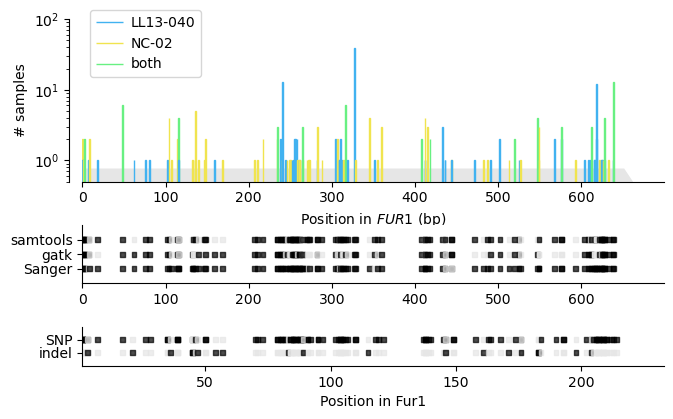

In [20]:
from matplotlib.legend_handler import HandlerPatch

fig, (ax, axfeat, ax1) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [0.625, 0.225, 0.15], 'hspace': 0.5}, figsize = (7.5,4.5))

# Plot mutations on nucleotide sequence on 1st row
for i in ['right','top']:
    ax.spines[i].set_visible(False)

# Large arrow for the gene
fa = FancyArrow(0, 0.5, 651, 0, width=0.5, head_length=651/65, head_width=0.5, color='0.9')
ax.add_patch(fa)

strain_combinations_cmap = {'LL13-040':'#41B2F0', 'NC-02':'#F0E44F', 'both':'#68F082'}
lz = list(zip(*map(by_snp.get, ['pos_nt', 'Nsamples', 'strain_combinations'])))
list_arrows_for_legend = []
for x in lz:
    m = FancyArrow(x[0], 0.5, 0, x[1]-0.5, width=1, head_length=0, head_width=0, color=strain_combinations_cmap[x[2]])
    ax.add_patch(m)
    if (x[0]==1) | (x[0]==2): # Very specific to the data - needs to be confirmed
        list_arrows_for_legend.append(m)
    
ax.set_yscale('log', base=10)
ax.set_xlim(0,699)
#ax.set_ylim(0.5, max_nt_samples+1)
ax.set_ylim(0.5, 100)
ax.spines['left'].set_position(('outward', 10))
ax.set_xlabel('Position in $\it{FUR1}$ (bp)')
ax.set_ylabel('# samples')

# Automatic legend for the plot on 1st row
def make_legend_arrow(legend, orig_handle,
                      xdescent, ydescent,
                      width, height, fontsize):
    p = FancyArrow(0, 0.5*height, width, 0, head_length=0, head_width=0 )
    return p
ax.legend(list_arrows_for_legend, ['LL13-040', 'NC-02', 'both'], # Careful - very specific to the data - needs to be confirmed
          bbox_to_anchor=(0.001,1.1),
          loc='upper left',
          handletextpad=0.5,
          handler_map={FancyArrow : HandlerPatch(patch_func=make_legend_arrow)})

# Custom legend for the plot on 1st row
# Currently only works with a linear y scale
#for i, (k,v) in enumerate(strain_combinations_cmap.items()):
#    l = FancyArrow(0, max_nt_samples-1.5*i, 10, 0, width=0.2, head_length=0, head_width=0, color=v)
#    ax.add_patch(l)
#    ax.text(15, max_nt_samples-1.5*i, k, verticalalignment='center')
    
# Plot features on 2nd row
for i in ['right','top']:
    axfeat.spines[i].set_visible(False)

axfeat.set_xlim(0,699)
axfeat.set_ylim(0, 4)
axfeat.set_yticks([3, 2, 1])
axfeat.set_yticklabels(['samtools','gatk','Sanger'])

for x in list(zip([3, 2, 1], ['samtools','gatk','Sanger'])):
    axfeat.scatter(by_snp.pos_nt.values, [x[0]]*len(by_snp.pos_nt.values), marker="s", s=12, c=by_snp[x[1]].map({0:'0.9', 1:'black'}), alpha=.7)

# Plot mutations on protein sequence on 3nd row
for i in ['right','top']:
    ax1.spines[i].set_visible(False)

#fa = FancyArrow(0, 5, 217, 0, width=5, head_length=217/65, head_width=5, color='0.9') # Arrow for the protein - unnecessary
#ax1.add_patch(fa)

ax1.set_xlim(1,233)
ax1.set_ylim(0, 3)
ax1.set_yticks([2, 1])
ax1.set_yticklabels(['SNP', 'indel'])

for x in list(zip([2, 1], ['SNP', 'indel'])):
    ax1.scatter(by_mut_aa.SNP_pos_aa.values, [x[0]]*len(by_mut_aa.SNP_pos_aa.values), marker="s", s=12, c=by_mut_aa[x[1]].map({0:'0.9', 1:'black'}), alpha=.7)

ax1.set_xlabel('Position in Fur1')

#plt.suptitle('Mutations identified in $\it{FUR1}$')

plt.savefig(graph_outpath + '/20230322_FUR1_mutations.png', format='png', dpi=300)
plt.savefig(graph_outpath + '/20230322_FUR1_mutations.svg', format='svg', dpi=300)

In [137]:
# Converting positions to C. albicans FUR1 to plot on cristal structure of tetramer
Scer_mutated_positions = [int(x) for x in by_mut_aa[by_mut_aa.indel==0].SNP_pos_aa.unique()]
Calb_mutated_positions = [x+2 for x in Scer_mutated_positions]
print(Calb_mutated_positions)

[3, 5, 9, 19, 28, 30, 37, 41, 47, 48, 52, 72, 73, 75, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 93, 94, 97, 99, 104, 105, 106, 107, 108, 109, 112, 120, 121, 123, 139, 140, 141, 142, 147, 148, 151, 160, 165, 166, 170, 176, 178, 186, 192, 195, 204, 206, 207, 208, 209, 210, 211, 212, 214, 215, 216]


In [138]:
# Two functions found here: https://rosettacode.org/wiki/Range_extraction#Procedural
# Helps generate the correct format to select residues on ChimeraX
def range_extract(lst):
    'Yield 2-tuple ranges or 1-tuple single elements from list of increasing ints'
    lenlst = len(lst)
    i = 0
    while i< lenlst:
        low = lst[i]
        while i <lenlst-1 and lst[i]+1 == lst[i+1]: i +=1
        hi = lst[i]
        if   hi - low >= 2:
            yield (low, hi)
        elif hi - low == 1:
            yield (low,)
            yield (hi,)
        else:
            yield (low,)
        i += 1


def printr(ranges):
    print( ','.join( (('%i-%i' % r) if len(r) == 2 else '%i' % r)
                     for r in ranges ) )

In [139]:
printr(range_extract(Calb_mutated_positions))

3,5,9,19,28,30,37,41,47,48,52,72,73,75,81-84,86-91,93,94,97,99,104-109,112,120,121,123,139-142,147,148,151,160,165,166,170,176,178,186,192,195,204,206-212,214-216
